# 📘 Theorie- und Einleitungsteil – SVHN Projektarbeit

## 1. Aufgabe (Task to solve)

In diesem Projekt soll ein Modell darauf trainiert werden, **Ziffern (0–9)** auf realen Straßenaufnahmen zu erkennen.
Es handelt sich um ein **multiklassiges Bildklassifikationsproblem**.
Das Modell soll jedem Eingabebild die wahrscheinlichste Klasse \(0,1,\dots,9\) zuordnen.

---

## 2. Datensatz (Data used)

Für das Projekt wird der **Street View House Numbers (SVHN)** Datensatz verwendet.

### 2.1 Datentyp
- Farbige **RGB-Bilder**
- Auflösung: **32 × 32 Pixel**
- Realweltaufnahmen von Hausnummern
- Jede Ziffer liegt als einzelnes Bild vor

### 2.2 Größe des Datensatzes
- **Training Set:** 73.257 Bilder
- **Test Set:** 26.032 Bilder
- **Additional Set:** 531.131 Bilder (optional)

### 2.3 Labels
- Labelbereich: **1–10**, wobei **10 die Ziffer 0** repräsentiert
- Labels werden vor Training entsprechend korrigiert

---

## 3. Modellarchitektur (Model architecture)

Es wird ein **Convolutional Neural Network (CNN)** verwendet, da CNNs besonders geeignet sind für Bilddaten aufgrund lokaler Mustererkennung.

Die geplante Architektur:

1. **Convolution Layer** (5×5, 3 → 10 Kanäle)
2. **Max-Pooling Layer** (2×2)
3. **ReLU-Aktivierung**
4. **Convolution Layer** (5×5, 10 → 20 Kanäle)
5. **Dropout2D**
6. **Max-Pooling Layer** (2×2)
7. **ReLU-Aktivierung**
8. **Flatten Layer**
9. **Fully Connected Layer** (auf 50 Neuronen)
10. **ReLU**
11. **Fully Connected Layer** (auf 10 Klassen)
12. **Log-Softmax-Ausgabe**

Dieses CNN extrahiert zuerst lokale Merkmale (Kanten, Formen), reduziert die räumlichen Dimensionen mittels Pooling und klassifiziert anschließend die resultierenden Feature Maps.

---

## 4. Basiseinstellungen für Training und Test (Basic training/testing setup)

### 4.1 Preprocessing
- Normalisierung der Pixelwerte auf Bereich \([0,1]\)
- Normalisierung jedes RGB-Kanals: Mittelwert 0.5, Standardabweichung 0.5

### 4.2 Hyperparameter
| Parameter | Wert |
|----------|------|
| Optimizer | SGD |
| Learning Rate | 0.01 |
| Momentum | 0.5 |
| Batch Size (Train) | 64 |
| Batch Size (Test) | 1000 |
| Epochen | 3 (Baseline) |
| Weight Initialization | Kaiming/He |

### 4.3 Loss Function
- **Negative Log Likelihood Loss (NLLLoss)**
- Wird mit **LogSoftmax** kombiniert

### 4.4 Trainingspipeline
1. Laden der Trainingsbatches
2. Forward Pass durch das CNN
3. Berechnung des NLL-Loss
4. Backpropagation
5. Update der Gewichte mit SGD
6. Wiederholung über mehrere Epochen

### 4.5 Evaluation
- Test-Loss
- Test-Accuracy
- Ausgabe der Modellvorhersagen auf Beispielbildern

---

## 5. Ziel des Projektes

- Aufbau eines funktionierenden CNNs für das SVHN-Dataset
- Durchführung **vier unterschiedlicher Experimente** (Hyperparameter- und Architekturvergleiche)
- Analyse und Visualisierung der Trainingsergebnisse
- Erkennen des Einflusses verschiedener Einstellungen wie:
  - Learning Rate
  - Optimizer
  - Netzwerkarchitektur
  - Batch Size
  - Weight Initialization

Ziel ist es, ein besseres Verständnis für das Verhalten neuronaler Netze und deren Hyperparameter in realen Bildklassifikationsproblemen zu entwickeln.


# Experiment

## wichtige Pakete einlesen

In [2]:
import torch                # PyTorch: das Hauptframework für Deep Learning (Tensors, Autograd, Modelle, Training)
import torchvision          # TorchVision: Bibliothek mit Standard-Datasets, Modellen und Bildtransformationen
import torch.nn as nn       # nn = Neural Network Module: für das Erstellen von Layern (z.B. Conv2d, Linear, ReLU)
import torch.nn.functional as F  # Funktionale API: für direkte Nutzung von Aktivierungsfunktionen, Losses, etc. (z.B. F.relu)
import torch.optim as optim       # Optimizer (z.B. SGD, Adam) für das Training von Modellen
import matplotlib.pyplot as plt   # Matplotlib: zum Plotten von Bildern, Trainingskurven oder Loss/Accuracy
import random                     # Python Standardbibliothek: für zufällige Zahlen, Shuffling, Seed-Kontrolle
import scipy.io# SciPy I/O: um .mat-Dateien (MATLAB-Format) zu laden, z.B. deine train/test Daten
from torch.utils.data import Dataset, DataLoader
                                  # Dataset: Basisklasse für eigene Datensätze
                                  # DataLoader: erleichtert Batch-Verarbeitung, Shuffling und Parallelisierung beim Training
import torchvision.transforms as transforms
                                  # Transformations für Bilder: z.B. Normalisierung, Resizing, RandomCrop, ToTensor



### Daten über torchvision

In [3]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

# Train-Set
train_dataset = datasets.SVHN(
    root="data",
    split='train',      # 'train' = train_32x32.mat
    download=True,      # lädt automatisch herunter, wenn nicht vorhanden
    transform=transform
)

# Test-Set
test_dataset = datasets.SVHN(
    root="data",
    split='test',       # 'test' = test_32x32.mat
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=1000, shuffle=False)


100.0%
100.0%


### Daten über seine eigene os

In [ ]:
transform = transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))

train_dataset = SVHNDataset('train_32x32.mat', transform=transform)
test_dataset  = SVHNDataset('test_32x32.mat',  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=1000, shuffle=False)


## SVHNDataset Klasse

In dieser Zelle wird eine **PyTorch Dataset-Klasse** für den SVHN-Datensatz definiert.

- **Zweck:** Ermöglicht es, `.mat`-Dateien mit Bildern und Labels einfach in PyTorch zu laden und in Batches zu verarbeiten.
- **Funktionen:**
  - `__init__`: Lädt die Daten aus der `.mat`-Datei und speichert optionale Transformationen.
  - `__len__`: Gibt die Anzahl der Bilder zurück (wichtig für DataLoader).
  - `__getitem__`: Liefert ein einzelnes Bild und Label als Tensor, normalisiert die Pixel und wendet Transformationen an.
- **Besonderheiten:**
  - Pixelwerte werden von [0,255] auf [0,1] normalisiert.
  - SVHN Label „10“ wird in `0` umgewandelt.
  - PyTorch erwartet die Kanal-Reihenfolge `(C,H,W)`, daher wird das Bild umgeformt.


In [5]:
class SVHNDataset(Dataset):
    # Wir erben von torch.utils.data.Dataset, damit PyTorch den DataLoader nutzen kann

    def __init__(self, mat_file, transform=None):
        # Konstruktor: Lädt die .mat-Datei und initialisiert Variablen
        data = scipy.io.loadmat(mat_file)   # scipy.io.loadmat: lädt MATLAB-Dateien
        self.X = data['X']                  # X enthält die Bilder: shape (32, 32, 3, N)
        self.y = data['y'].flatten()        # y enthält Labels: shape (N,). flatten() macht aus Spaltenvektor 1D-Array
        self.transform = transform          # Transformationsobjekt für Bildvorverarbeitung (optional)

        # SVHN-Spezialfall: Label "10" bedeutet Ziffer "0"
        self.y[self.y == 10] = 0

    def __len__(self):
        # Gibt die Anzahl der Samples zurück, damit DataLoader weiß, wie viele es gibt
        return self.X.shape[3]              # N = Anzahl Bilder

    def __getitem__(self, idx):
        # Liefert ein einzelnes Sample (Bild + Label) für Index idx
        img = self.X[:,:,:,idx]             # Bild: (32,32,3)
        # torch.tensor: konvertiert numpy-array zu Tensor
        # permute(2,0,1): PyTorch erwartet Kanal zuerst (C,H,W) statt H,W,C
        # float()/255.0: normalisiert Pixelwerte von [0,255] auf [0,1]
        img = torch.tensor(img).permute(2,0,1).float()/255.0
        label = int(self.y[idx])            # Label als Integer

        if self.transform:
            img = self.transform(img)       # Falls Transform gesetzt, anwenden (z.B. RandomCrop, Normalize)

        return img, label                     # Rückgabe: Tensorbild + Label


## Überblick über die Test- und Trainingsdaten
In dieser Zelle werden die Dateien im aktuellen Projektverzeichnis aufgelistet und die Größen der Trainings- und Testdaten angezeigt.

- `os.listdir()`: Listet alle Dateien und Ordner im aktuellen Verzeichnis auf.
- `os.path.getsize(path)`: Gibt die Größe einer Datei in Bytes zurück.
- Die Größe der `.mat`-Dateien wird in Megabyte (MB) umgerechnet, um die Dateigröße übersichtlich darzustellen.
- Ziel: Überprüfen, dass die Trainings- und Testdaten vorhanden sind und wie groß sie sind.

In [6]:
import os  # Zugriff auf Betriebssystemfunktionen (Dateien, Verzeichnisse)

# Liste alle Dateien und Ordner im aktuellen Verzeichnis auf
#for f in os.listdir():
#    print(f)  # Druckt jeden Dateinamen / Ordnernamen

# Größe der Trainingsdaten berechnen (Bytes → MB) und ausgeben
print("train:", os.path.getsize("train_32x32.mat")/1024/1024, "MB")

# Größe der Testdaten berechnen (Bytes → MB) und ausgeben
print("test :", os.path.getsize("test_32x32.mat")/1024/1024, "MB")



FileNotFoundError: [Errno 2] No such file or directory: 'train_32x32.mat'

## Beispiel der Trainingsdaten


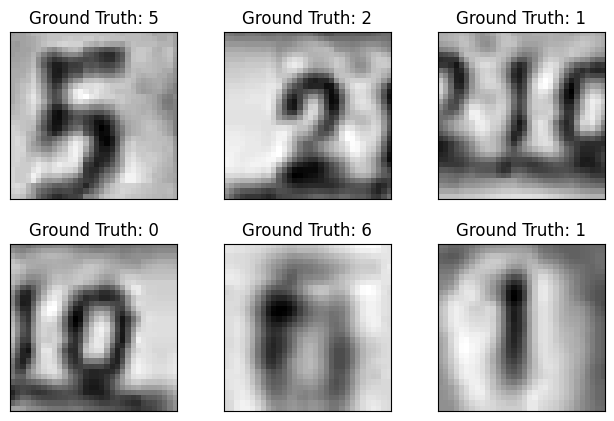

In [7]:
# Iterator über den Test-DataLoader erstellen
examples = enumerate(test_loader)

# Den ersten Batch aus dem Test-DataLoader holen
batch_idx, (example_data, example_targets) = next(examples)

# Neue Figur für die Plots erstellen
fig = plt.figure()

# 6 Bilder aus dem Batch plotten
for i in range(6):
    # Unterteilt die Figur in 2x3 Raster, i+1 = aktuelle Position
    plt.subplot(2, 3, i+1)
    plt.tight_layout()  # Sorgt dafür, dass Plots sich nicht überlappen
    # Zeige das Bild an; example_data[i][0] = 1. Kanal (Graustufe)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    # Titel mit Ground-Truth-Label
    plt.title("Ground Truth: {}".format(example_targets[i]))
    # Achsenbeschriftungen entfernen
    plt.xticks([])
    plt.yticks([])

# Alle geplotteten Bilder anzeigen
plt.show()


## Definition des CNN-Modells

In dieser Zelle wird die Klasse `Net` definiert, die ein Convolutional Neural Network (CNN) implementiert.

- **Zweck:** Definiert die Architektur des neuronalen Netzes für Bilderkennung.
- **Aufbau:**
  1. Convolutional Layer (Feature Extraction)
  2. Max-Pooling (Reduzierung der Dimensionen)
  3. ReLU (Nichtlinearität)
  4. Dropout (Regularisierung)
  5. Flatten (Umwandlung in 1D für Fully Connected Layer)
  6. Fully Connected Layer(s) (klassische Klassifizierung)
  7. Softmax (Wahrscheinlichkeitsausgabe für Klassen)
- **TODO-Liste im Kommentar:** Zeigt, welche Layer du für ein vollständiges CNN einbauen solltest.


In [11]:
# TODO Change this class to implement
# 1. A valid convolution with kernel size 5, 1 input channel and 10 output channels
# 2. A max pooling operation over a 2x2 area
# 3. A Relu
# 4. A valid convolution with kernel size 5, 10 input channels and 20 output channels
# 5. A 2D Dropout layer
# 6. A max pooling operation over a 2x2 area
# 7. A relu
# 8. A flattening operation
# 9. A fully connected layer mapping from (whatever dimensions we are at-- find out using .shape) to 50
# 10. A ReLU
# 11. A fully connected layer mapping from 50 to 10 dimensions
# 12. A softmax function.

# Replace this class which implements a minimal network (which still does okay)

# CNN-Klasse definieren
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # --- Erster Convolutional Layer ---
        # nn.Conv2d: 2D Convolution
        # 3 Input-Kanäle (RGB), 10 Output-Kanäle (Features), Kernelgröße 5x5
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)  # TODO: ggf. auf 1 Input-Kanal anpassen für Graustufen

        # Dropout für die Convolutionen (reduziert Overfitting)
        self.drop = nn.Dropout2d()

        # Fully Connected Layer
        # nn.Linear: verbindet alle Eingangseinheiten mit allen Ausgangseinheiten
        # 1960 Eingangsdimensionen → 1000 Ausgangsdimensionen (muss evtl. an tatsächliche Flatten-Größe angepasst werden)
        self.fc1 = nn.Linear(1960, 1000)

    # --- Forward-Pass ---
    def forward(self, x):
        x = self.conv1(x)               # 1. Convolution
        x = self.drop(x)                # 2. Dropout
        x = F.max_pool2d(x, 2)          # 3. Max-Pooling über 2x2
        x = F.relu(x)                   # 4. ReLU-Aktivierung
        x = x.flatten(1)                # 5. Flattening: CxHxW → 1D für Fully Connected Layer
        x = self.fc1(x)                 # 6. Fully Connected Layer
        x = F.log_softmax(x)            # 7. Log-Softmax für Klassenausgabe
        return x                        # Rückgabe: Log-Wahrscheinlichkeiten pro Klasse

In [12]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

## Initialisierung des Modells, der Gewichte und des Optimizers

In dieser Zelle wird das neuronale Netz erstellt, seine Gewichte initialisiert und der Optimizer definiert.

- `model = Net()`: Erstellt eine Instanz des zuvor definierten CNN-Modells.
- `model.apply(weights_init)`: Wendet eine eigene Initialisierungsfunktion (`weights_init`) auf alle Layer des Modells an.
  Dies sorgt dafür, dass die Anfangsgewichte der Layer sinnvoll gesetzt werden, was das Lernen stabiler und schneller macht.
- `optim.SGD(...)`: Erstellt einen Stochastic Gradient Descent Optimizer.
  - `model.parameters()`: Übergibt die trainierbaren Parameter des Modells.
  - `lr=0.01`: Lernrate.
  - `momentum=0.5`: Verbessert die Konvergenzgeschwindigkeit, indem vorherige Gradienten berücksichtigt werden.


In [37]:
# Erstellt eine Instanz des CNN-Modells (Klasse Net aus vorheriger Zelle)
model = Net()

# Initialisiert die Gewichte aller Layer mit einer benutzerdefinierten Funktion weights_init
# Dadurch starten die Gewichte nicht zufällig schlecht, was Training verbessern kann
model.apply(weights_init)

# Definiert den Optimizer: Stochastic Gradient Descent
# model.parameters(): alle trainierbaren Parameter des Modells
# lr=0.01: Lernrate
# momentum=0.5: hilft, "Schwankungen" im Gradienten auszugleichen
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


## Trainingsroutine

In dieser Zelle wird die Trainingsfunktion `train(epoch)` definiert.
Sie führt einen kompletten Trainingsdurchlauf (Epoch) über den gesamten Trainingsdatensatz aus.

Ablauf:
1. `model.train()`: Schaltet das Modell in den Trainingsmodus (aktiviert z.B. Dropout).
2. Schleife über alle Batches im `train_loader`.
3. `optimizer.zero_grad()`: Setzt Gradienten des vorherigen Backpropagation-Schritts zurück.
4. `output = model(data)`: Modellvorhersage für den aktuellen Batch.
5. `loss = F.nll_loss(...)`: Berechnet die Negative Log-Likelihood Loss (passend für `log_softmax`).
6. `loss.backward()`: Backpropagation – berechnet Gradienten.
7. `optimizer.step()`: Aktualisiert die Modellparameter.
8. Alle 10 Batches wird der aktuelle Trainingsfortschritt (Loss) ausgegeben.


In [38]:
# Haupt-Trainingsroutine
def train(epoch):
    model.train()  # Modell in den Trainingsmodus setzen (Dropout aktiv, BatchNorm aktiviert)

    # Schleife über alle Batches im Training DataLoader
    for batch_idx, (data, target) in enumerate(train_loader):

        optimizer.zero_grad()       # Vor jedem Schritt Gradienten zurücksetzen

        output = model(data)        # Modellvorhersage für aktuellen Batch
        loss = F.nll_loss(output, target)  # Loss berechnen (für log_softmax geeignet)

        loss.backward()             # Backpropagation: Gradienten berechnen
        optimizer.step()            # Parameter-Update mittels Optimizer

        # Fortschrittsanzeige alle 10 Batches
        if batch_idx % 10 == 0:
            print(
                'Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                    epoch,                          # Aktuelle Epoche
                    batch_idx * len(data),          # Anzahl verarbeiteter Trainingsbeispiele
                    len(train_loader.dataset),      # Gesamtzahl der Trainingsdaten
                    loss.item()                     # Aktueller Loss-Wert
                )
            )


## Test-/Evaluierungsroutine

In dieser Zelle wird die Funktion `test()` definiert, die das Modell auf den Testdaten auswertet.

Ablauf:
1. `model.eval()`: Setzt das Modell in den Evaluierungsmodus
   (Dropout deaktiviert, BatchNorm verwendet Durchschnittswerte).
2. `torch.no_grad()`: Deaktiviert Gradientenberechnung – spart Zeit und Speicher.
3. Schleife über `test_loader`:
   - Modellvorhersagen berechnen
   - Loss aufsummieren (für Durchschnitt am Ende)
   - Vorhersagen mit den Zielwerten vergleichen → Accuracy
4. Nach der Schleife:
   - Durchschnitts-Loss berechnen
   - Genauigkeit berechnen und ausgeben


In [39]:
# Testfunktion, um das Modell auf den Testdaten auszuwerten
def test():
    model.eval()      # Modell in den Evaluierungsmodus setzen (Dropout aus)
    test_loss = 0     # Summe der Loss-Werte
    correct = 0       # Anzahl korrekter Vorhersagen

    # Im Testmodus keine Gradienten berechnen → schneller und spart Speicher
    with torch.no_grad():
        # Schleife über alle Test-Batches
        for data, target in test_loader:

            output = model(data)  # Modellvorhersage

            # Addiere den Loss des Batches (size_average=False = Summe statt Mittelwert)
            test_loss += F.nll_loss(output, target, reduction='sum').item()

            # Wähle die Klasse mit der höchsten Wahrscheinlichkeit
            pred = output.data.max(1, keepdim=True)[1]

            # Vergleiche Vorhersagen mit dem Ground-Truth
            correct += pred.eq(target.data.view_as(pred)).sum()

    # Durchschnittlichen Loss berechnen
    test_loss /= len(test_loader.dataset)

    # Ergebnisse ausgeben
    print(
        '\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)
        )
    )

## Ausführen des Trainings und Testens über mehrere Epochen

In dieser Zelle wird zuerst die Anfangsleistung des Modells auf den Testdaten berechnet („untrainiertes Modell“).
Anschließend wird das Modell über mehrere Epochen trainiert. Nach jeder Epoche wird erneut getestet, um den Fortschritt zu messen.

Ablauf:
1. `test()`: Bewertung des Modells vor dem Training (Baseline).
2. `n_epochs = 3`: Anzahl der Trainingsdurchläufe (Epochen).
3. Schleife über alle Epochen:
   - `train(epoch)`: Trainingsdurchlauf über alle Trainingsdaten.
   - `test()`: Bewertung der Modellleistung nach dieser Epoche.


In [40]:
# Anfangsleistung des Modells testen (ungelerntes Modell)
test()

# Anzahl der Trainings-Epochen festlegen
n_epochs = 3

# Trainings-/Testschleife über mehrere Epochen
for epoch in range(1, n_epochs + 1):
    train(epoch)  # Modell trainieren
    test()        # Modell nach der Epoche testen


/var/folders/gm/d7swcmj57md2th2_r0b315x80000gn/T/ipykernel_38549/299424523.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)            # 7. Log-Softmax für Klassenausgabe



Test set: Avg. loss: 7.0260, Accuracy: 0/26032 (0%)

Train Epoch: 1 [0/73257]	Loss: 7.019948
Train Epoch: 1 [1280/73257]	Loss: 5.422011
Train Epoch: 1 [2560/73257]	Loss: 4.442428
Train Epoch: 1 [3840/73257]	Loss: 3.591133
Train Epoch: 1 [5120/73257]	Loss: 3.523211
Train Epoch: 1 [6400/73257]	Loss: 3.417609
Train Epoch: 1 [7680/73257]	Loss: 3.326477
Train Epoch: 1 [8960/73257]	Loss: 3.509353
Train Epoch: 1 [10240/73257]	Loss: 3.236801
Train Epoch: 1 [11520/73257]	Loss: 3.747551
Train Epoch: 1 [12800/73257]	Loss: 3.316441
Train Epoch: 1 [14080/73257]	Loss: 3.606859
Train Epoch: 1 [15360/73257]	Loss: 4.066888
Train Epoch: 1 [16640/73257]	Loss: 3.446515
Train Epoch: 1 [17920/73257]	Loss: 3.195255
Train Epoch: 1 [19200/73257]	Loss: 3.382719
Train Epoch: 1 [20480/73257]	Loss: 3.588111
Train Epoch: 1 [21760/73257]	Loss: 3.586449
Train Epoch: 1 [23040/73257]	Loss: 3.592638
Train Epoch: 1 [24320/73257]	Loss: 3.387845
Train Epoch: 1 [25600/73257]	Loss: 3.451303
Train Epoch: 1 [26880/73257]	Loss

## Vorhersagen des trainierten Modells visualisieren

In dieser Zelle wird das Modell auf einige zuvor geladene Beispielbilder angewendet.
Die Predictions (Vorhersagen) werden zusammen mit den Bildern dargestellt.

Ablauf:
1. `output = model(example_data)`: Modell erzeugt Vorhersagen für die ausgewählten Testbilder.
2. `plt.figure()`: Neue Plot-Figur.
3. Schleife über mehrere Bilder:
   - Bild anzeigen (`imshow`)
   - Modellvorhersage ermitteln (`output.data.max(...)`)
   - Prediction als Titel ausgeben
   - Achsen entfernen
4. `plt.show()`: Darstellung der Ergebnisse.


/var/folders/gm/d7swcmj57md2th2_r0b315x80000gn/T/ipykernel_38549/299424523.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)            # 7. Log-Softmax für Klassenausgabe


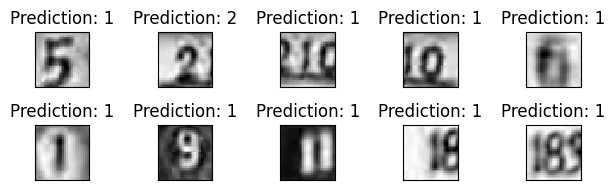

In [41]:
# Modellvorhersagen für die zuvor geladenen Beispielbilder berechnen
output = model(example_data)

# Neue Figur für die Plots erstellen
fig = plt.figure()

# Zeige die ersten 10 Bilder und ihre Vorhersagen
for i in range(10):
    plt.subplot(5, 5, i+1)  # 5x5 Raster, aktueller Plot: i+1
    plt.tight_layout()      # Überlappungen vermeiden

    # Beispielbild anzeigen (Graustufe)
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')

    # Vorhersage ermitteln:
    # max(1) → höchste Wahrscheinlichkeit entlang der Klassenachse
    # [1] → Index des Maximums → vorhergesagte Klasse
    predicted_label = output.data.max(1, keepdim=True)[1][i].item()

    # Titel mit der Vorhersage
    plt.title("Prediction: {}".format(predicted_label))

    # Achsen entfernen
    plt.xticks([])
    plt.yticks([])

# Plots anzeigen
plt.show()


## Erweiterung zur Lösungsdarstellung für den "Buchcode"

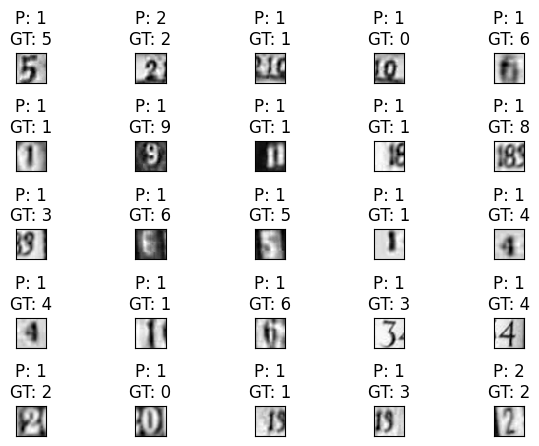

In [42]:
num_images = 25
for i in range(num_images):
    plt.subplot(5, 5, i+1)  # 5x5 Raster
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    predicted_label = output.data.max(1, keepdim=True)[1][i].item()
    plt.title(f"P: {predicted_label}\nGT: {example_targets[i]}")
    plt.xticks([])
    plt.yticks([])
plt.show()

/var/folders/gm/d7swcmj57md2th2_r0b315x80000gn/T/ipykernel_38549/299424523.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)            # 7. Log-Softmax für Klassenausgabe


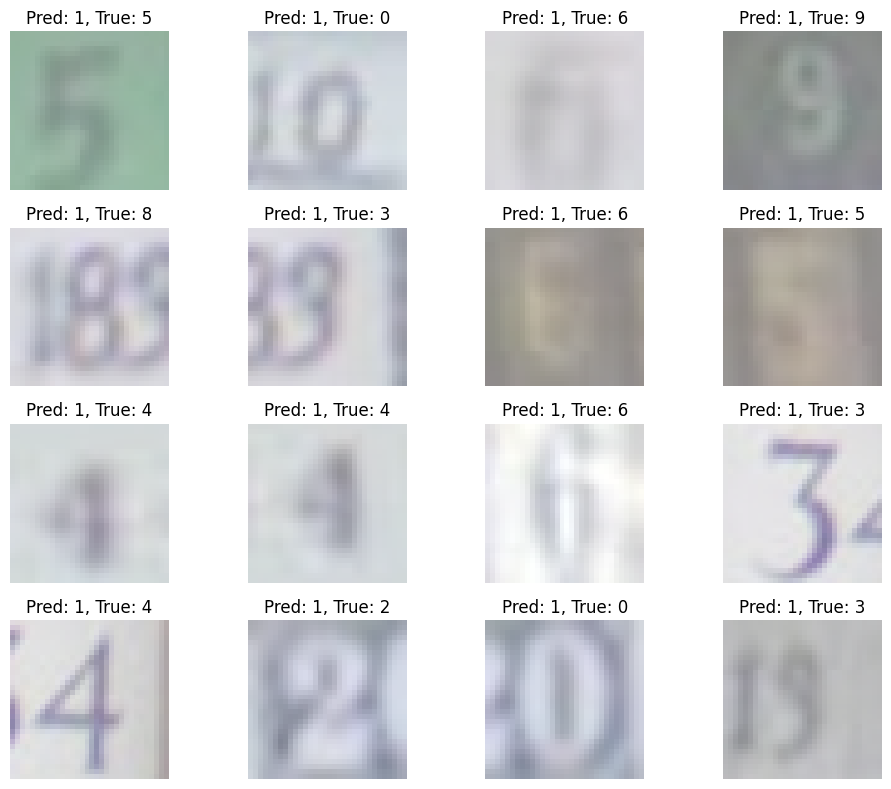

In [43]:
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Beispielhafte Normalisierung (anpassen, falls anders trainiert)
mean = torch.tensor([0.5, 0.5, 0.5], device=device)
std = torch.tensor([0.5, 0.5, 0.5], device=device)

# Denormalisieren für matplotlib
def denormalize(img):
    img = img.permute(1, 2, 0)  # CxHxW -> HxWxC
    img = img * std + mean       # Denormalisieren
    img = img.clamp(0, 1)
    return img.cpu()

model.eval()
misclassified = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Fehlklassifikationen sammeln
        for img, pred, label in zip(images, preds, labels):
            if pred != label:
                misclassified.append((img, pred.item(), label.item()))
        if len(misclassified) >= 16:  # max 16 Bilder
            break

# Plotten der Fehlklassifikationen
fig, axes = plt.subplots(4, 4, figsize=(10, 8))
axes = axes.flatten()

for i, (img, pred, label) in enumerate(misclassified[:16]):
    axes[i].imshow(denormalize(img))
    axes[i].set_title(f"Pred: {pred}, True: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [50]:
# Wähle ein Bild aus dem Testset
image, label = next(iter(test_loader))
image = image[1].unsqueeze(0)  # nur ein Bild, Batch-Dimension hinzufügen

tensor([[[[0.5059, 0.4980, 0.4902,  ..., 0.4745, 0.4824, 0.4824],
          [0.5255, 0.5216, 0.5176,  ..., 0.4980, 0.4941, 0.4902],
          [0.5529, 0.5490, 0.5490,  ..., 0.5294, 0.5176, 0.5098],
          ...,
          [0.5765, 0.5569, 0.5333,  ..., 0.3647, 0.3765, 0.4078],
          [0.5412, 0.5098, 0.4745,  ..., 0.3647, 0.3961, 0.4392],
          [0.5137, 0.4784, 0.4353,  ..., 0.3961, 0.4353, 0.4824]],

         [[0.5569, 0.5608, 0.5608,  ..., 0.5216, 0.5255, 0.5294],
          [0.5882, 0.5843, 0.5843,  ..., 0.5412, 0.5373, 0.5373],
          [0.6196, 0.6157, 0.6157,  ..., 0.5765, 0.5608, 0.5529],
          ...,
          [0.6314, 0.6118, 0.5922,  ..., 0.3804, 0.3922, 0.4275],
          [0.5961, 0.5647, 0.5333,  ..., 0.3882, 0.4196, 0.4627],
          [0.5686, 0.5333, 0.4941,  ..., 0.4235, 0.4627, 0.5098]],

         [[0.6000, 0.5961, 0.5922,  ..., 0.6000, 0.6118, 0.6157],
          [0.6275, 0.6196, 0.6157,  ..., 0.6157, 0.6157, 0.6196],
          [0.6588, 0.6510, 0.6471,  ..., 0

/var/folders/gm/d7swcmj57md2th2_r0b315x80000gn/T/ipykernel_38549/299424523.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)            # 7. Log-Softmax für Klassenausgabe


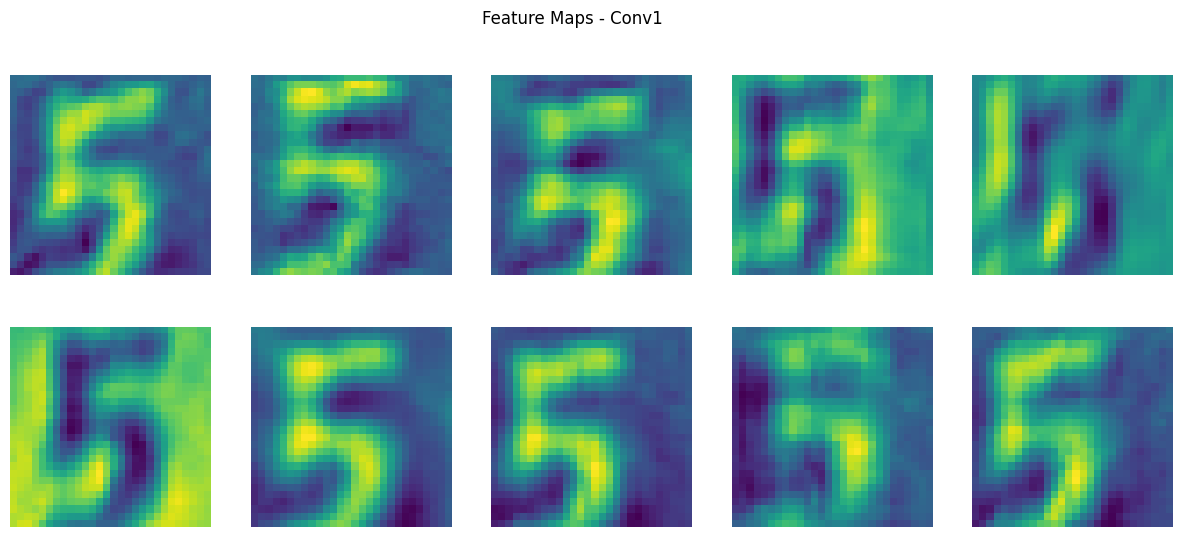

In [52]:
# Wähle ein Bild aus dem Testset
image, label = next(iter(test_loader))
image = image[0].unsqueeze(0)  # nur ein Bild, Batch-Dimension hinzufügen

model.eval()
activations = []

# Hook für die Layer-Outputs
def get_activation(name):
    def hook(model, input, output):
        activations.append(output.detach())
    return hook

# Hooks für die ersten beiden Conv-Layer
model.conv1.register_forward_hook(get_activation('conv1'))
#model.conv2.register_forward_hook(get_activation('conv2'))

# Forward Pass
_ = model(image)

# Plot der Feature Maps von Layer 1
act = activations[0].squeeze(0)  # Batch-Dimension entfernen
num_maps = act.shape[0]           # Anzahl der Feature Maps

# Automatisch ein passendes Grid erstellen
cols = 5
rows = (num_maps + cols - 1) // cols

plt.figure(figsize=(cols*3, rows*3))
for i, fmap in enumerate(act):
    plt.subplot(rows, cols, i+1)
    plt.imshow(fmap.cpu(), cmap='viridis')
    plt.axis('off')

plt.suptitle("Feature Maps - Conv1")
plt.show()


In [54]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def grad_cam(model, image, target_class=None):
    model.eval()
    activations = []
    gradients = []

    # Forward hook
    def forward_hook(module, input, output):
        activations.append(output)

    # Backward hook
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Hooks registrieren
    #handle_f = model.conv2.register_forward_hook(forward_hook)
    #handle_b = model.conv2.register_backward_hook(backward_hook)  # <-- regulärer Backward-Hook

    # Forward pass
    output = model(image)
    if target_class is None:
        target_class = output.argmax(dim=1)

    # Gradienten berechnen
    model.zero_grad()
    loss = output[0, target_class]
    loss.backward()

    # Grad-CAM berechnen
    activation = activations[0].detach()
    gradient = gradients[0].detach()
    weights = gradient.mean(dim=(2,3), keepdim=True)
    grad_cam_map = F.relu((weights * activation).sum(dim=1)).squeeze()
    grad_cam_map = grad_cam_map / grad_cam_map.max()

    # Hooks wieder entfernen
    #handle_f.remove()
    #handle_b.remove()
    
    # Denormalisieren und Werte begrenzen
    img = image[0].cpu()             # Batch-Dimension entfernen
    img = img * 0.5 + 0.5            # falls Normalize(mean=0.5,std=0.5) benutzt wurde
    img = img.clamp(0,1)             # erzwingt Werte zwischen 0 und 1

    # Plot
    plt.imshow(img.permute(1,2,0))   # Originalbild, korrekt denormalisiert
    plt.imshow(grad_cam_map.cpu(), cmap='jet', alpha=0.5)  # Heatmap
    plt.axis('off')
    plt.show()


# Beispielaufruf:
image, label = next(iter(test_loader))
image = image[0].unsqueeze(0)
grad_cam(model, image)



/var/folders/gm/d7swcmj57md2th2_r0b315x80000gn/T/ipykernel_38549/299424523.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)            # 7. Log-Softmax für Klassenausgabe


IndexError: list index out of range

/var/folders/gm/d7swcmj57md2th2_r0b315x80000gn/T/ipykernel_38549/299424523.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)            # 7. Log-Softmax für Klassenausgabe


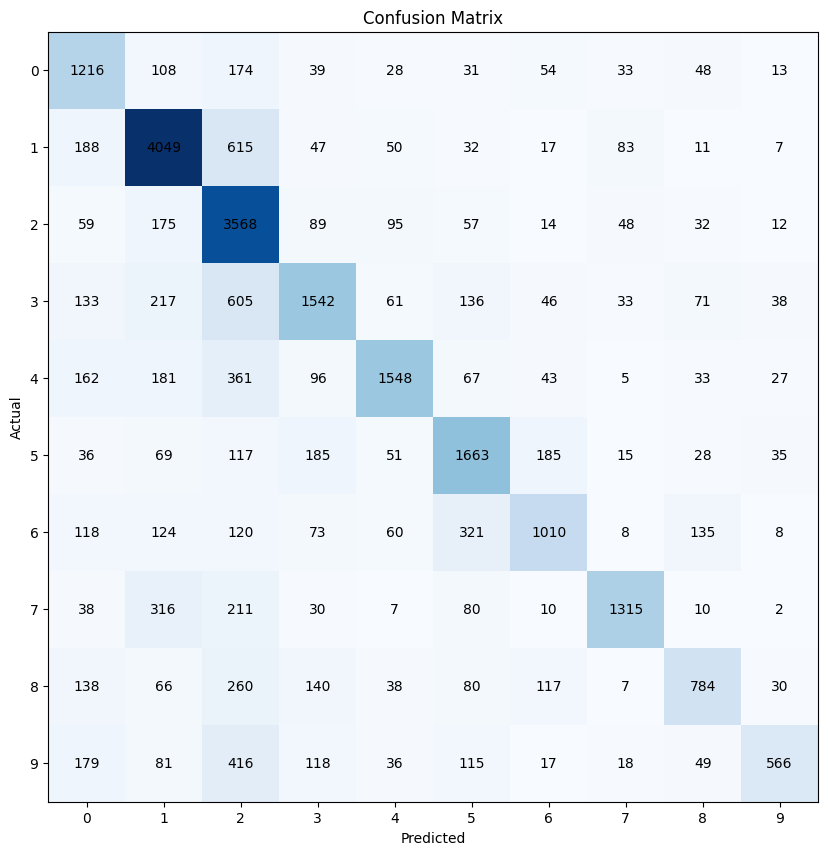

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Alle Vorhersagen und Labels sammeln
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        preds = output.data.max(1, keepdim=True)[1]  # vorhergesagte Klasse
        all_preds.extend(preds.view(-1).tolist())
        all_targets.extend(target.view(-1).tolist())

# Confusion Matrix erstellen
cm = confusion_matrix(all_targets, all_preds)

# Plotten mit Matplotlib
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(cm, cmap='Blues')

# Achsenbeschriftungen
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

# Achsenticks
classes = np.arange(10)  # für Ziffern 0-9
ax.set_xticks(classes)
ax.set_yticks(classes)

# Zahlen in die Zellen schreiben
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.show()

Häufigste vorhergesagte Klasse: 3


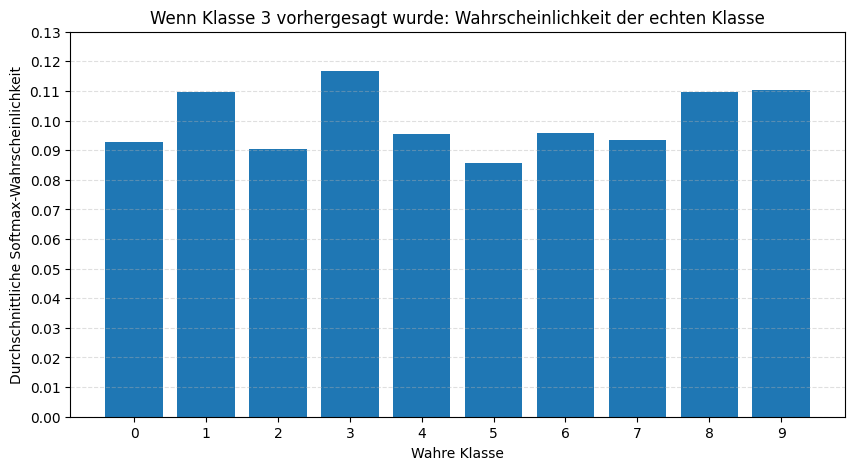

NameError: name 'probs' is not defined

<Figure size 800x500 with 0 Axes>

In [27]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

model.eval()
softmax = torch.nn.Softmax(dim=1)

# 1) Häufigste vorhergesagte Klasse bestimmen
pred_counts = torch.zeros(10)

for images, _ in test_loader:
    outputs = model(images)
    preds = outputs.argmax(dim=1)
    for p in preds:
        pred_counts[p] += 1

TARGET_CLASS = torch.argmax(pred_counts).item()
print("Häufigste vorhergesagte Klasse:", TARGET_CLASS)


# 2) Softmax-Werte für echte Klassen sammeln,
#    aber NUR wenn die Vorhersage = TARGET_CLASS ist
probs_per_true_label = [[] for _ in range(10)]

for images, labels in test_loader:
    outputs = model(images)
    probabilities = softmax(outputs)
    preds = probabilities.argmax(dim=1)

    for i in range(len(preds)):
        if preds[i] == TARGET_CLASS:
            true_label = labels[i].item()
            probs_per_true_label[true_label].append(
                probabilities[i, true_label].item()
            )


# 3) Durchschnitt berechnen
avg_probs = [sum(v)/len(v) if len(v) > 0 else 0 for v in probs_per_true_label]


# 4) Plot
plt.figure(figsize=(10,5))
plt.bar(range(10), avg_probs)

plt.xticks(range(10))
plt.xlabel("Wahre Klasse")
plt.ylabel("Durchschnittliche Softmax-Wahrscheinlichkeit")
plt.title(f"Wenn Klasse {TARGET_CLASS} vorhergesagt wurde: Wahrscheinlichkeit der echten Klasse")

# Neue Y-Achse: 0 bis 0.13 in 0.01 Schritten
plt.ylim(0, 0.13)
plt.yticks([i/100 for i in range(0, 14, 1)])  

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()



# --- Streudiagramm ---
plt.figure(figsize=(8,5))
plt.scatter(classes, probs.numpy(), color='red', s=100)

plt.xticks(classes)
plt.xlabel("Klassen")
plt.ylabel("Softmax Wahrscheinlichkeit")
plt.title(f"Streudiagramm der Softmax-Wahrscheinlichkeiten (Vorhersage: {pred_class})")

# Neue Y-Achse: 0 bis 0.15 mit 0.02 Schritten
plt.ylim(0, 0.15)
plt.yticks([i/100 for i in range(0, 16, 2)])  

plt.grid(True, linestyle='--', alpha=0.4)
plt.show()



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             760
            Conv2d-2           [-1, 20, 24, 24]           5,020
            Linear-3                   [-1, 50]         576,050
            Linear-4                   [-1, 10]             510
Total params: 582,340
Trainable params: 582,340
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.15
Params size (MB): 2.22
Estimated Total Size (MB): 2.38
----------------------------------------------------------------


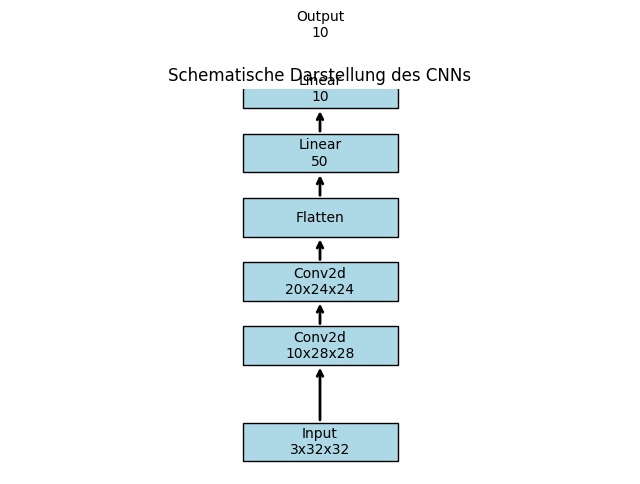

In [28]:
from torchsummary import summary

# Zeige Struktur für Input-Größe (z.B. 3x32x32 für SVHN)
summary(model, input_size=(3,32,32))



import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# --- Einfaches CNN ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc1 = nn.Linear(20*24*24, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()

# --- Netzwerkdiagramm zeichnen ---
def plot_network():
    fig, ax = plt.subplots(figsize=(8,5))
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 6)
    ax.axis('off')
    
    layers = [
        ("Input\n3x32x32", 0.5),
        ("Conv2d\n10x28x28", 2),
        ("Conv2d\n20x24x24", 3),
        ("Flatten", 4),
        ("Linear\n50", 5),
        ("Linear\n10", 6),
        ("Output\n10", 7)
    ]
    
    # Layer zeichnen
    for name, y in layers:
        ax.add_patch(plt.Rectangle((3, y-0.3), 2, 0.6, color='lightblue', ec='black'))
        ax.text(4, y, name, ha='center', va='center')
    
    # Pfeile zeichnen
    for i in range(len(layers)-1):
        y1 = layers[i][1]
        y2 = layers[i+1][1]
        ax.annotate("", xy=(4, y2-0.3), xytext=(4, y1+0.3),
                    arrowprops=dict(arrowstyle="->", lw=2))
    
    plt.title("Schematische Darstellung des CNNs")
    plt.show()

plot_network()


## Chat GPT Ergänzungen

### Flexible CNN-Architektur für SVHN

Diese Zelle definiert ein flexibles Convolutional Neural Network (CNN) für das SVHN-Datenset.

Besonderheiten:
- Anzahl der Convolutional Layers kann gewählt werden (`num_conv_layers=1 oder 2`)
- Konfigurierbare Dropout-Rate (`dropout_rate`)
- Größe des Fully Connected Hidden Layers ist einstellbar (`fc_hidden`)
- Automatische Berechnung der richtigen Flatten-Dimension abhängig von Netzwerkarchitektur
- Die Architektur besteht aus:
  1. Convolution + ReLU + MaxPool
  2. Optional: zweite Convolution + Dropout + ReLU + MaxPool
  3. Flatten
  4. Fully Connected Layer
  5. Output-Layer mit 10 Klassen
  6. `log_softmax` für NLLLoss-kompatible Wahrscheinlichkeitsverteilung


```yaml
   ┌───────────────┐
   │ Input Image   │
   │ 3 × 32 × 32   │
   └───────┬───────┘
           │
   Conv1: 10 Feature Maps, Kernel 5×5
           │
   ReLU Activation
           │
   MaxPool 2×2
           │
   ┌───────────────┐
   │ Output Conv1  │
   │ 10 × 14 × 14  │
   └───────┬───────┘
           │
   Conv2: 20 Feature Maps, Kernel 5×5
           │
   Dropout 0.3
           │
   ReLU Activation
           │
   MaxPool 2×2
           │
   ┌───────────────┐
   │ Output Conv2  │
   │ 20 × 5 × 5    │
   └───────┬───────┘
           │
   Flatten: 20*5*5 = 500
           │
   Fully Connected: fc1 → 50 Neuronen
           │
   ReLU
           │
   Fully Connected: fc2 → 10 Klassen
           │
   Log-Softmax Output
           │
   ┌───────────────┐
   │ Predictions   │
   │ 10 classes    │
   └───────────────┘
```

```yaml
# Das ist nur ein Code-Block in Markdown, wird nicht interpretiert
num_conv_layers: 2
dropout_rate: 0.3
fc_hidden: 50
```

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SVHNCNN(nn.Module):
    def __init__(
        self,
        num_conv_layers=2,   # Anzahl der Convolutional Layer (1 oder 2)
        dropout_rate=0.3,    # Dropout-Wahrscheinlichkeit
        fc_hidden=50         # Anzahl der Neuronen im Fully Connected Hidden Layer
    ):
        super().__init__()

        self.num_conv_layers = num_conv_layers

        # --- 1. Convolution Layer ---
        # Eingabe: 3 Kanäle (RGB), Ausgabe: 10 Feature Maps, Kernel 5x5
        # Bildgröße: 32x32 -> 28x28
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)

        # --- 2. Convolution Layer (optional) ---
        # Eingabe: 10 Feature Maps, Ausgabe: 20 Feature Maps
        # Bildgröße nach Conv2: 14x14 -> 10x10
        if num_conv_layers >= 2:
            self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        else:
            self.conv2 = None

        # --- Dropout Layer ---
        # Dropout für Convolution Outputs (Spatial Dropout)
        self.dropout = nn.Dropout2d(p=dropout_rate)

        # ============================================
        # AUTOMATISCHE BERECHNUNG DER FC-EINGANGSGRÖSSE
        # ============================================

        # Wenn nur eine Conv-Schicht:
        # conv1: 32 → 28 → MaxPool → 14
        # Feature Maps: 10
        if num_conv_layers == 1:
            conv_output_dim = 10 * 14 * 14

        # Wenn zwei Conv-Schichten:
        # conv1: 32 → 28 → pool → 14
        # conv2: 14 → 10 → pool → 5
        # Feature Maps: 20
        else:
            conv_output_dim = 20 * 5 * 5

        # --- Fully Connected Layers ---
        self.fc1 = nn.Linear(conv_output_dim, fc_hidden)
        self.fc2 = nn.Linear(fc_hidden, 10)  # 10 Klassen (Ziffern 0–9)

    def forward(self, x):

        # --- Block 1 ---
        x = F.relu(self.conv1(x))     # Convolution + ReLU
        x = F.max_pool2d(x, 2)        # MaxPooling 2x2

        # --- Optionaler Block 2 ---
        if self.conv2 is not None:
            x = F.relu(self.dropout(self.conv2(x)))  # Conv2 → Dropout → ReLU
            x = F.max_pool2d(x, 2)                   # Pooling 2x2

        # --- Flatten der Feature Maps ---
        x = x.view(x.size(0), -1)

        # --- Fully Connected Layers ---
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # --- Output: Log-Softmax für NLLLoss ---
        return F.log_softmax(x, dim=1)


## Experiment 1

In [30]:
model_A = SVHNCNN(num_conv_layers=1)
model_B = SVHNCNN(num_conv_layers=2)


### Experiment 2: learning rates

In [31]:
for lr in [0.1, 0.01, 0.001]:
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)


### Experiment 3: SGD vs. ADAM

In [32]:
optimizer_SGD = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
optimizer_Adam = torch.optim.Adam(model.parameters(), lr=0.001)


### Experiment 4: verschiedene Batch-Sizes

In [33]:
for bs in [32, 64, 128]:
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)


## Training, Test und Output

### Experimente: Einfluss von Netzwerktiefe, Learning Rate, Optimizer und Batch Size

In dieser Zelle werden vier systematische Experimente durchgeführt, um den Einfluss verschiedener Hyperparameter auf ein CNN für SVHN zu analysieren:

1. **Netzwerktiefe**
   Vergleich zwischen 1 und 2 Convolutional Layers.

2. **Learning Rate**
   Vergleich der Lernraten: 0.1, 0.01, 0.001.

3. **Optimizer**
   Vergleich zwischen klassischem SGD und Adam.

4. **Batch Size**
   Training mit Batchgrößen: 32, 64, 128.

Alle Trainings- und Testergebnisse werden gespeichert und am Ende zusammen in einem Accuracy-Plot dargestellt.


In [64]:
# --- Hilfsfunktion: Training + Testen ---
def run_training(model, optimizer, train_loader, test_loader, n_epochs=3, exp_info=""):
    """
    Führt Training + Testen über mehrere Epochen durch.
    Gibt Listen von Training Loss, Test Loss und Accuracy zurück.
    """
    train_losses, test_losses, test_accuracies = [], [], []

    for epoch in range(1, n_epochs + 1):

        # ===== Training =====
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
        train_losses.append(loss.item())

        # ===== Testen =====
        model.eval()
        test_loss = 0
        correct = 0

        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()

        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)

        test_losses.append(test_loss)
        test_accuracies.append(accuracy)

        # Ausgabe mit optionalem Experiment-Info
        prefix = f"[{exp_info}] " if exp_info else ""
        print(f"{prefix}Epoch {epoch} | Test Acc: {accuracy:.2f}% | Test Loss: {test_loss:.4f}")

    return train_losses, test_losses, test_accuracies


In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# --- Experiment Setup ---
n_epochs = 3  # für schnelle Tests, später erhöhen
train_batch_sizes = [64]  # Basiswert, außer Experiment 4
test_batch_size = 1000

In [34]:
# Dictionary zum Speichern aller Ergebnisse
all_results = {}
# ============================================================
# EXPERIMENT 1 — Einfluss der Netzwerktiefe
# ============================================================
print("=== Experiment 1: Netzwerktiefe ===")

models = {
    "1_Conv": SVHNCNN(num_conv_layers=1),
    "2_Conv": SVHNCNN(num_conv_layers=2)
}

for name, model in models.items():
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    train_losses, test_losses, accuracies = run_training(model, optimizer, train_loader, test_loader, n_epochs)
    all_results[f"Exp1_{name}"] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "accuracy": accuracies,
        "model": model
    }


# ============================================================
# EXPERIMENT 2 — Learning Rate Vergleich
# ============================================================
print("\n=== Experiment 2: Learning Rate ===")

lrs = [0.1, 0.01, 0.001]

for lr in lrs:
    model = SVHNCNN(num_conv_layers=2)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)
    train_losses, test_losses, accuracies = run_training(model, optimizer, train_loader, test_loader, n_epochs)
    all_results[f"Exp2_LR_{lr}"] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "accuracy": accuracies,
        "model": model
    }


# ============================================================
# EXPERIMENT 3 — Optimizer Vergleich
# ============================================================
print("\n=== Experiment 3: Optimizer ===")

optimizers = {
    "SGD": torch.optim.SGD,
    "Adam": torch.optim.Adam
}

for name, opt_class in optimizers.items():
    model = SVHNCNN(num_conv_layers=2)

    # typische Default-Learning-Rates
    if name == "SGD":
        optimizer = opt_class(model.parameters(), lr=0.01, momentum=0.5)
    else:
        optimizer = opt_class(model.parameters(), lr=0.001)

    train_losses, test_losses, accuracies = run_training(model, optimizer, train_loader, test_loader, n_epochs)
    all_results[f"Exp3_{name}"] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "accuracy": accuracies,
        "model": model
    }


# ============================================================
# EXPERIMENT 4 — Batch Size Vergleich
# ============================================================
print("\n=== Experiment 4: Batch Size ===")

batch_sizes = [32, 64, 128]

for bs in batch_sizes:
    train_loader_exp = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    model = SVHNCNN(num_conv_layers=2)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

    train_losses, test_losses, accuracies = run_training(
        model, optimizer, train_loader_exp, test_loader, n_epochs
    )

    all_results[f"Exp4_BS_{bs}"] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "accuracy": accuracies,
        "model": model
    }


# ============================================================
# PLOT ALLER EXPERIMENT-ERGEBNISSE
# ============================================================

for key, res in all_results.items():
    plt.plot(range(1, n_epochs+1), res["accuracy"], label=key)

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy pro Experiment")
plt.legend()
plt.show()


=== Experiment 1: Netzwerktiefe ===
Epoch 1 | Test Acc: 19.59% | Test Loss: 2.2194
Epoch 2 | Test Acc: 23.54% | Test Loss: 2.1368
Epoch 3 | Test Acc: 39.64% | Test Loss: 1.8307
Epoch 1 | Test Acc: 19.59% | Test Loss: 2.2267
Epoch 2 | Test Acc: 19.77% | Test Loss: 2.2124
Epoch 3 | Test Acc: 27.60% | Test Loss: 2.0625

=== Experiment 2: Learning Rate ===


KeyboardInterrupt: 

### gleiche Output Plots wie oben

#### jetzt mit anderer Epochenzahl

=== Experiment 1: Netzwerktiefe ===
Epoch 1 | Test Acc: 19.59% | Test Loss: 2.2242
Epoch 2 | Test Acc: 20.91% | Test Loss: 2.1893
Epoch 3 | Test Acc: 29.99% | Test Loss: 2.0129
Epoch 1 | Test Acc: 19.59% | Test Loss: 2.2259
Epoch 2 | Test Acc: 19.59% | Test Loss: 2.2246
Epoch 3 | Test Acc: 19.61% | Test Loss: 2.2115

=== Experiment 2: Learning Rate ===
Epoch 1 | Test Acc: 76.14% | Test Loss: 0.8337
Epoch 2 | Test Acc: 82.97% | Test Loss: 0.5902
Epoch 3 | Test Acc: 83.07% | Test Loss: 0.5821
Epoch 1 | Test Acc: 19.59% | Test Loss: 2.2258
Epoch 2 | Test Acc: 19.59% | Test Loss: 2.2225
Epoch 3 | Test Acc: 19.51% | Test Loss: 2.2097
Epoch 1 | Test Acc: 19.59% | Test Loss: 2.2553
Epoch 2 | Test Acc: 19.59% | Test Loss: 2.2322
Epoch 3 | Test Acc: 19.59% | Test Loss: 2.2291

=== Experiment 3: Optimizer ===
Epoch 1 | Test Acc: 19.59% | Test Loss: 2.2274
Epoch 2 | Test Acc: 19.59% | Test Loss: 2.2249
Epoch 3 | Test Acc: 19.59% | Test Loss: 2.2236
Epoch 1 | Test Acc: 79.09% | Test Loss: 0.7815
E

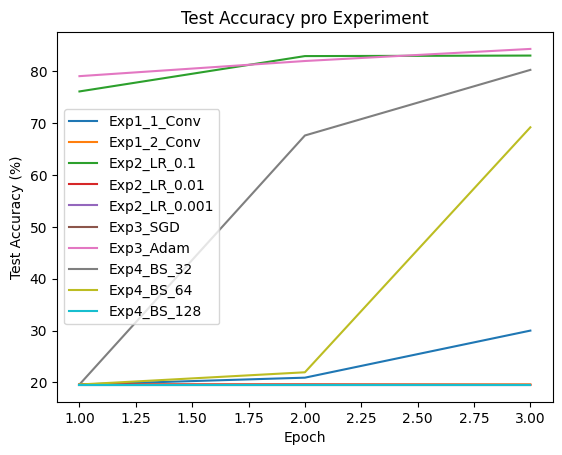

In [35]:
# --- Experiment Setup ---
n_epochs = 10  # für schnelle Tests, später erhöhen
train_batch_sizes = [64]  # Basiswert, außer Experiment 4
test_batch_size = 1000

# Dictionary zum Speichern aller Ergebnisse
all_results = {}
# --- Experiment 1: Einfluss der Netzwerktiefe ---
print("=== Experiment 1: Netzwerktiefe ===")
models = {
    "1_Conv": SVHNCNN(num_conv_layers=1),
    "2_Conv": SVHNCNN(num_conv_layers=2)
}
for name, model in models.items():
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    train_losses, test_losses, accuracies = run_training(model, optimizer, train_loader, test_loader, n_epochs)
    all_results[f"Exp1_{name}"] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "accuracy": accuracies
    }

# --- Experiment 2: Learning Rate ---
print("\n=== Experiment 2: Learning Rate ===")
lrs = [0.1, 0.01, 0.001]
for lr in lrs:
    model = SVHNCNN(num_conv_layers=2)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)
    train_losses, test_losses, accuracies = run_training(model, optimizer, train_loader, test_loader, n_epochs)
    all_results[f"Exp2_LR_{lr}"] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "accuracy": accuracies
    }

# --- Experiment 3: Optimizer Vergleich ---
print("\n=== Experiment 3: Optimizer ===")
optimizers = {
    "SGD": torch.optim.SGD,
    "Adam": torch.optim.Adam
}
for name, opt_class in optimizers.items():
    model = SVHNCNN(num_conv_layers=2)
    if name == "SGD":
        optimizer = opt_class(model.parameters(), lr=0.01, momentum=0.5)
    else:
        optimizer = opt_class(model.parameters(), lr=0.001)
    train_losses, test_losses, accuracies = run_training(model, optimizer, train_loader, test_loader, n_epochs)
    all_results[f"Exp3_{name}"] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "accuracy": accuracies
    }

# --- Experiment 4: Batch Size ---
print("\n=== Experiment 4: Batch Size ===")
batch_sizes = [32, 64, 128]
for bs in batch_sizes:
    train_loader_exp = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    model = SVHNCNN(num_conv_layers=2)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    train_losses, test_losses, accuracies = run_training(model, optimizer, train_loader_exp, test_loader, n_epochs)
    all_results[f"Exp4_BS_{bs}"] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "accuracy": accuracies
    }

# --- Plots: Accuracy pro Experiment ---
for key, res in all_results.items():
    plt.plot(range(1, n_epochs+1), res["accuracy"], label=key)

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy pro Experiment")
plt.legend()
plt.show()


### mit 5 Layern
Flexible SVHN CNN mit 1–5 Convolutional Layers

Dieser Code definiert eine **flexible Convolutional Neural Network (CNN) Architektur für das SVHN-Dataset**, die zwischen 1 und 5 Convolutional Layers variieren kann.
Die Architektur umfasst:
- Mehrere Convolutional Layers mit ReLU-Aktivierungen
- Max-Pooling nach bestimmten Convs
- Spatial Dropout nach der letzten Convolution
- Fully Connected Layers für die Klassifikation in 10 Klassen (Ziffern 0–9)
- Log-Softmax am Output für die Nutzung mit `NLLLoss`


In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SVHNC5NN(nn.Module):
    def __init__(
        self,
        num_conv_layers=5,   # Anzahl der Convolutional Layers, flexibel 1–5
        dropout_rate=0.3,    # Dropout-Wahrscheinlichkeit nach Convs
        fc_hidden=50         # Anzahl der Neuronen im Fully Connected Hidden Layer
    ):
        super().__init__()

        # Sicherstellen, dass num_conv_layers im erlaubten Bereich liegt
        assert 1 <= num_conv_layers <= 5, "num_conv_layers muss zwischen 1 und 5 liegen"
        self.num_conv_layers = num_conv_layers

        # --- Convolutional Layers ---
        # Erstellen einer flexiblen Liste von Conv-Layern
        self.convs = nn.ModuleList()
        in_channels = 3  # RGB-Bilder haben 3 Kanäle
        out_channels_list = [10, 20, 30, 40, 50]  # Ausgabekanäle pro Layer
        kernel_sizes = [5, 5, 3, 3, 3]           # Kernelgrößen pro Layer

        for i in range(num_conv_layers):
            # Conv Layer erstellen und zur Liste hinzufügen
            self.convs.append(nn.Conv2d(in_channels, out_channels_list[i], kernel_size=kernel_sizes[i]))
            in_channels = out_channels_list[i]

        # Dropout Layer nach dem letzten Conv
        self.dropout = nn.Dropout2d(p=dropout_rate)

        # --- Dummy Forward Pass ---
        # Berechnung der Flatten-Dimension automatisch
        dummy_input = torch.zeros(1, 3, 32, 32)  # 1 Dummy-Bild
        x = dummy_input
        for i, conv in enumerate(self.convs):
            x = F.relu(conv(x))
            # MaxPooling nach Layer 2 und 4 (optional)
            if i in [1, 3]:
                x = F.max_pool2d(x, 2)
        self.flatten_dim = x.numel()  # Anzahl der Features nach Flatten

        # --- Fully Connected Layers ---
        self.fc1 = nn.Linear(self.flatten_dim, fc_hidden)  # Hidden Layer
        self.fc2 = nn.Linear(fc_hidden, 10)               # Output Layer: 10 Klassen (Ziffern)

    def forward(self, x):
        # --- Convolutional Forward Pass ---
        for i, conv in enumerate(self.convs):
            x = F.relu(conv(x))
            if i in [1, 3]:
                x = F.max_pool2d(x, 2)  # Max-Pooling nach Layer 2 und 4

        # Dropout anwenden
        x = self.dropout(x)

        # Flatten für Fully Connected Layer
        x = x.view(x.size(0), -1)

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Log-Softmax für NLLLoss
        return F.log_softmax(x, dim=1)


=== Experiment 1: Netzwerktiefe ===
Epoch 1 | Test Acc: 19.61% | Test Loss: 2.2195
Epoch 2 | Test Acc: 30.07% | Test Loss: 2.0667
Epoch 3 | Test Acc: 56.56% | Test Loss: 1.4603
Epoch 1 | Test Acc: 19.59% | Test Loss: 2.2258
Epoch 2 | Test Acc: 22.51% | Test Loss: 2.1650
Epoch 3 | Test Acc: 59.37% | Test Loss: 1.3628
Epoch 1 | Test Acc: 19.59% | Test Loss: 2.2271
Epoch 2 | Test Acc: 19.59% | Test Loss: 2.2241
Epoch 3 | Test Acc: 19.59% | Test Loss: 2.2232
Epoch 1 | Test Acc: 19.59% | Test Loss: 2.2254
Epoch 2 | Test Acc: 19.59% | Test Loss: 2.2243
Epoch 3 | Test Acc: 19.59% | Test Loss: 2.2240
Epoch 1 | Test Acc: 19.59% | Test Loss: 2.2251
Epoch 2 | Test Acc: 19.59% | Test Loss: 2.2189
Epoch 3 | Test Acc: 29.89% | Test Loss: 2.0018


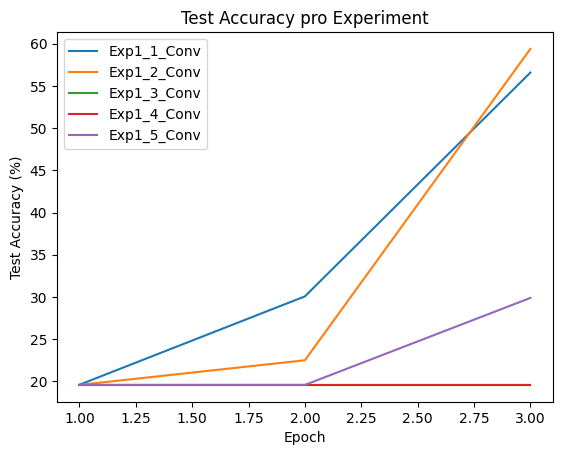

In [60]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# --- Experiment Setup ---
n_epochs = 3  # für schnelle Tests, später erhöhen
train_batch_sizes = [64]  # Basiswert, außer Experiment 4
test_batch_size = 1000

# Dictionary zum Speichern aller Ergebnisse
all_results = {}


# --- Experiment 1: Einfluss der Netzwerktiefe ---
print("=== Experiment 1: Netzwerktiefe ===")
models = {
    "1_Conv": SVHNC5NN(num_conv_layers=1),
    "2_Conv": SVHNC5NN(num_conv_layers=2),
    "3_Conv": SVHNC5NN(num_conv_layers=3),
    "4_Conv": SVHNC5NN(num_conv_layers=4),
    "5_Conv": SVHNC5NN(num_conv_layers=2)
}
for name, model in models.items():
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    train_losses, test_losses, accuracies = run_training(model, optimizer, train_loader, test_loader, n_epochs)
    all_results[f"Exp1_{name}"] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "accuracy": accuracies
    }

# --- Plots: Accuracy pro Experiment ---
for key, res in all_results.items():
    plt.plot(range(1, n_epochs+1), res["accuracy"], label=key)

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy pro Experiment")
plt.legend()
plt.show()



=== Experiment 2: Learning Rate & Netzwerktiefe ===

--- Training: 2 Conv-Layer | LR = 0.1 ---
Epoch 1 | Conv-Layers: 2 | LR: 0.1 | Test Accuracy: 57.79% | Test Loss: 1.3063
Epoch 2 | Conv-Layers: 2 | LR: 0.1 | Test Accuracy: 83.41% | Test Loss: 0.5786
Epoch 3 | Conv-Layers: 2 | LR: 0.1 | Test Accuracy: 84.59% | Test Loss: 0.5369

--- Training: 2 Conv-Layer | LR = 0.01 ---
Epoch 1 | Conv-Layers: 2 | LR: 0.01 | Test Accuracy: 19.59% | Test Loss: 2.2250
Epoch 2 | Conv-Layers: 2 | LR: 0.01 | Test Accuracy: 19.59% | Test Loss: 2.2235
Epoch 3 | Conv-Layers: 2 | LR: 0.01 | Test Accuracy: 19.59% | Test Loss: 2.2038

--- Training: 2 Conv-Layer | LR = 0.001 ---
Epoch 1 | Conv-Layers: 2 | LR: 0.001 | Test Accuracy: 19.07% | Test Loss: 2.2605
Epoch 2 | Conv-Layers: 2 | LR: 0.001 | Test Accuracy: 19.56% | Test Loss: 2.2308
Epoch 3 | Conv-Layers: 2 | LR: 0.001 | Test Accuracy: 19.59% | Test Loss: 2.2292

--- Training: 3 Conv-Layer | LR = 0.1 ---
Epoch 1 | Conv-Layers: 3 | LR: 0.1 | Test Accuracy: 

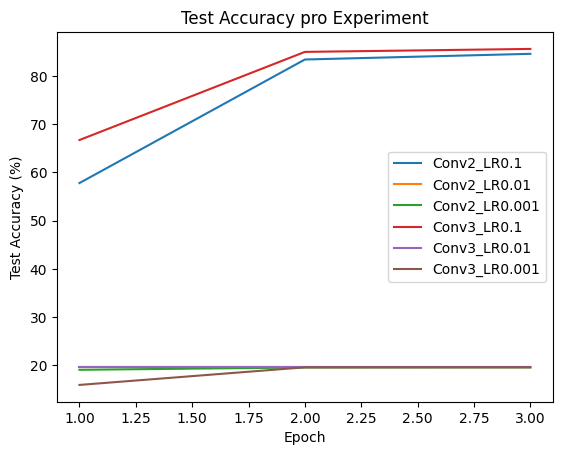

In [62]:
# --- Experiment 2: Einfluss der Learning Rate und Conv-Layer ---
import matplotlib.pyplot as plt

# Dictionary zum Speichern aller Ergebnisse
learning_results = {}
lrs = [0.1, 0.01, 0.001]
conv_layers_list = [2, 3]  # Anzahl der Conv-Layer, die getestet werden sollen

print("\n=== Experiment 2: Learning Rate & Netzwerktiefe ===")

for num_conv in conv_layers_list:
    for lr in lrs:
        # Modell erstellen
        model = SVHNC5NN(num_conv_layers=num_conv)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)

        print(f"\n--- Training: {num_conv} Conv-Layer | LR = {lr} ---")

        train_losses, test_losses, accuracies = [], [], []
        for epoch in range(1, n_epochs + 1):
            # Training
            model.train()
            for data, target in train_loader:
                optimizer.zero_grad()
                output = model(data)
                loss = F.nll_loss(output, target)
                loss.backward()
                optimizer.step()
            train_losses.append(loss.item())

            # Test
            model.eval()
            test_loss = 0
            correct = 0
            with torch.no_grad():
                for data, target in test_loader:
                    output = model(data)
                    test_loss += F.nll_loss(output, target, reduction='sum').item()
                    pred = output.argmax(dim=1)
                    correct += pred.eq(target).sum().item()
            test_loss /= len(test_loader.dataset)
            accuracy = 100. * correct / len(test_loader.dataset)
            test_losses.append(test_loss)
            accuracies.append(accuracy)

            # Ausgabe nach jeder Epoche
            print(f"Epoch {epoch} | Conv-Layers: {num_conv} | LR: {lr} | Test Accuracy: {accuracy:.2f}% | Test Loss: {test_loss:.4f}")

        # Ergebnisse speichern
        learning_results[f"Conv{num_conv}_LR{lr}"] = {
            "train_loss": train_losses,
            "test_loss": test_losses,
            "accuracy": accuracies
        }

# --- Plots: Accuracy pro Experiment ---
for key, res in learning_results.items():
    plt.plot(range(1, n_epochs+1), res["accuracy"], label=key)

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy pro Experiment")
plt.legend()
plt.show()


In [65]:
all_results = {}

# --- Experiment 1: Standardeinstellung, Netzwerktiefe ---
print("=== Experiment 1: Netzwerktiefe (Standard) ===")
for num_conv in [1, 2, 3, 4, 5]:
    model = SVHNC5NN(num_conv_layers=num_conv)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    exp_info = f"{num_conv} Conv-Layer | LR=0.01 | Optimizer=SGD | Batch=64"
    train_losses, test_losses, accuracies = run_training(
        model, optimizer, train_loader, test_loader, n_epochs, exp_info=exp_info
    )
    all_results[exp_info] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "accuracy": accuracies
    }

# --- Weitere Experimente: Learning Rate, Optimizer, Batch Size ---
conv_layers_list = [2, 3]  # Nur 2 und 3 Layer
lrs = [0.2, 0.1, 0.01]
optimizers_dict = {
    "SGD": lambda params, lr: torch.optim.SGD(params, lr=lr, momentum=0.5),
    "Adam": lambda params, lr: torch.optim.Adam(params, lr=lr)
}
batch_sizes = [32, 64, 128]

for num_conv in conv_layers_list:
    for lr in lrs:
        for opt_name, opt_func in optimizers_dict.items():
            for bs in batch_sizes:
                train_loader_exp = DataLoader(train_dataset, batch_size=bs, shuffle=True)
                model = SVHNC5NN(num_conv_layers=num_conv)
                optimizer = opt_func(model.parameters(), lr)
                exp_info = f"{num_conv} Conv-Layer | LR={lr} | Optimizer={opt_name} | Batch={bs}"
                train_losses, test_losses, accuracies = run_training(
                    model, optimizer, train_loader_exp, test_loader, n_epochs, exp_info=exp_info
                )
                all_results[exp_info] = {
                    "train_loss": train_losses,
                    "test_loss": test_losses,
                    "accuracy": accuracies
                }

# --- Ergebnisse plotten ---
import matplotlib.pyplot as plt
for key, res in all_results.items():
    plt.plot(range(1, n_epochs+1), res["accuracy"], label=key)

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy pro Experiment")
plt.legend(fontsize=6)
plt.show()


=== Experiment 1: Netzwerktiefe (Standard) ===
[1 Conv-Layer | LR=0.01 | Optimizer=SGD | Batch=64] Epoch 1 | Test Acc: 19.59% | Test Loss: 2.2213
[1 Conv-Layer | LR=0.01 | Optimizer=SGD | Batch=64] Epoch 2 | Test Acc: 26.89% | Test Loss: 2.1241
[1 Conv-Layer | LR=0.01 | Optimizer=SGD | Batch=64] Epoch 3 | Test Acc: 47.28% | Test Loss: 1.6194
[2 Conv-Layer | LR=0.01 | Optimizer=SGD | Batch=64] Epoch 1 | Test Acc: 19.59% | Test Loss: 2.2257
[2 Conv-Layer | LR=0.01 | Optimizer=SGD | Batch=64] Epoch 2 | Test Acc: 19.59% | Test Loss: 2.2210
[2 Conv-Layer | LR=0.01 | Optimizer=SGD | Batch=64] Epoch 3 | Test Acc: 22.47% | Test Loss: 2.1503
[3 Conv-Layer | LR=0.01 | Optimizer=SGD | Batch=64] Epoch 1 | Test Acc: 19.59% | Test Loss: 2.2257


KeyboardInterrupt: 

In [ ]:
# --- Experiment 4: Batch Size ---
# Dictionary zum Speichern aller Ergebnisse
batch_results = {}
print("\n=== Experiment 4: Batch Size ===")
batch_sizes = [32, 64, 128]
for bs in batch_sizes:
    train_loader_exp = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    model = SVHNC5NN(num_conv_layers=2)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    train_losses, test_losses, accuracies = run_training(model, optimizer, train_loader_exp, test_loader, n_epochs)
    batch_results[f"Exp4_BS_{bs}"] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "accuracy": accuracies
    }
for bs in batch_sizes:
    train_loader_exp = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    model = SVHNC5NN(num_conv_layers=3)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    train_losses, test_losses, accuracies = run_training(model, optimizer, train_loader_exp, test_loader, n_epochs)
    batch_results[f"Exp4_BS_{bs}"] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "accuracy": accuracies
    }
# --- Plots: Accuracy pro Experiment ---
for key, res in batch_results.items():
    plt.plot(range(1, n_epochs+1), res["accuracy"], label=key)

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy pro Experiment")
plt.legend()
plt.show()

## Veranschaulichung der Ergebnisse für 3 Epochen
#### Musste für jedes Experiment eine Stelle ändern:
all_results[f"Exp3_{name}"] = {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "accuracy": accuracies,
        "model": model      # -> hinzugefügt (4 mal, also einmal pro "Experiment")
    }

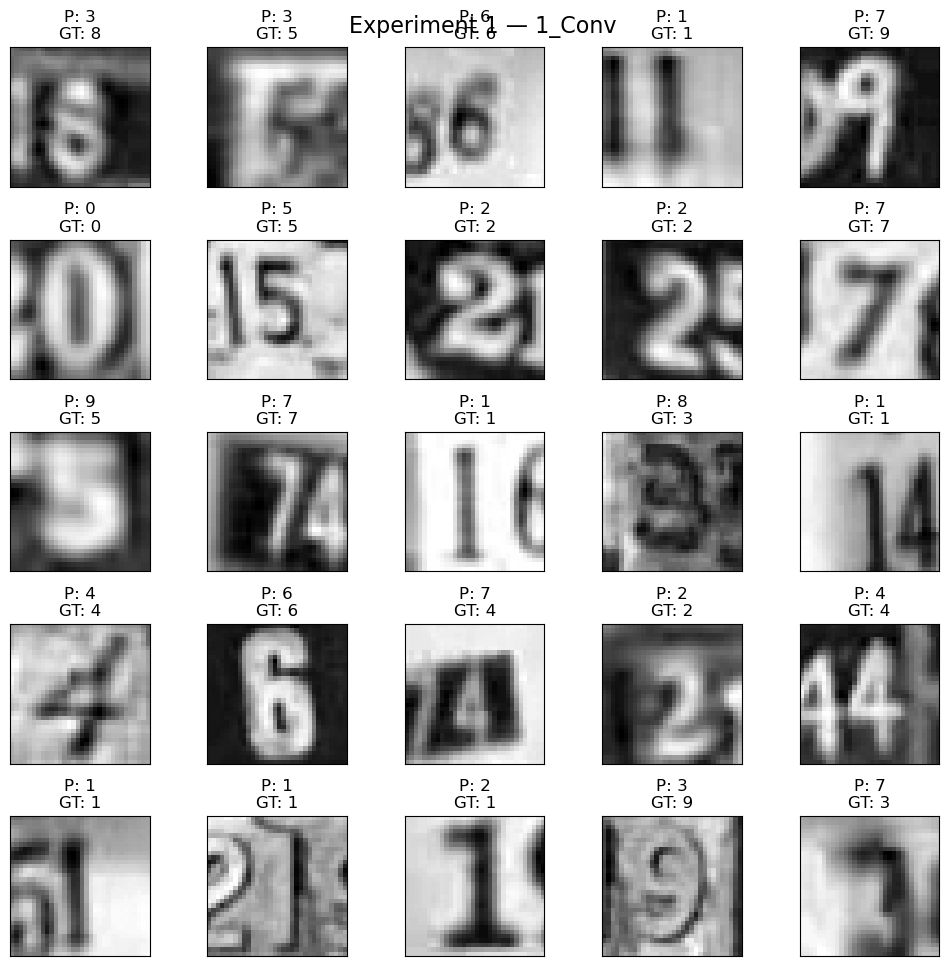

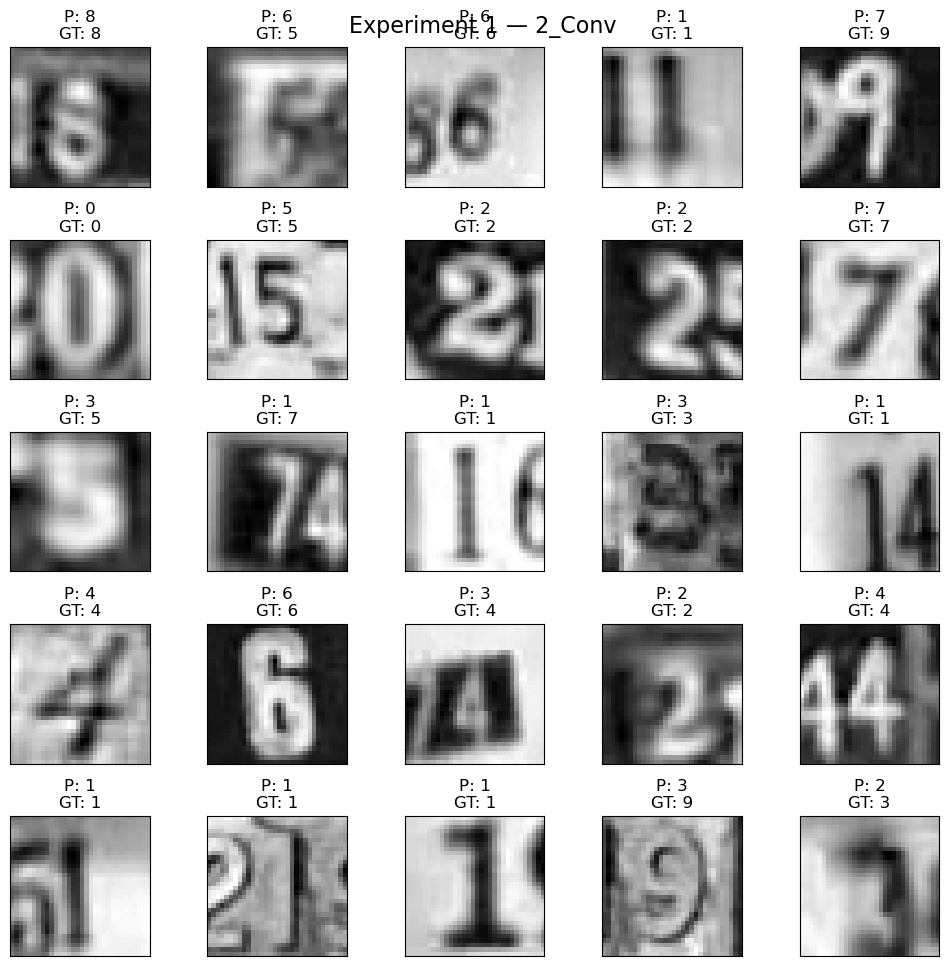

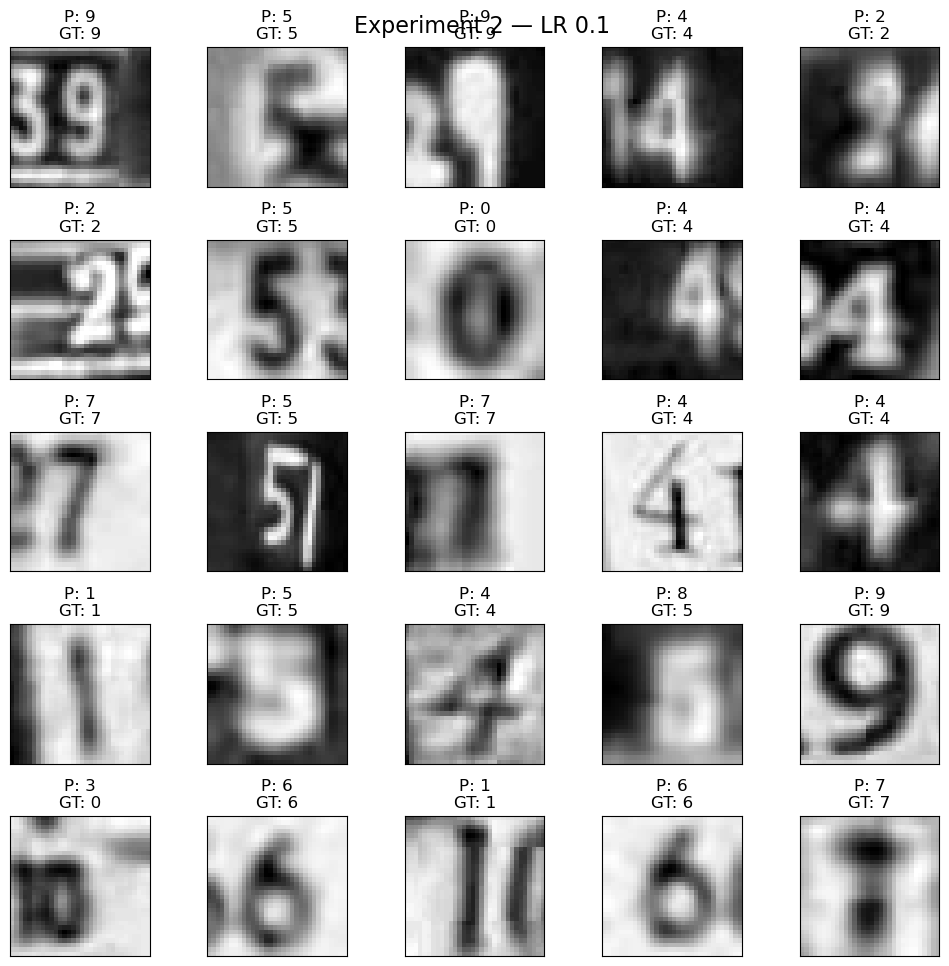

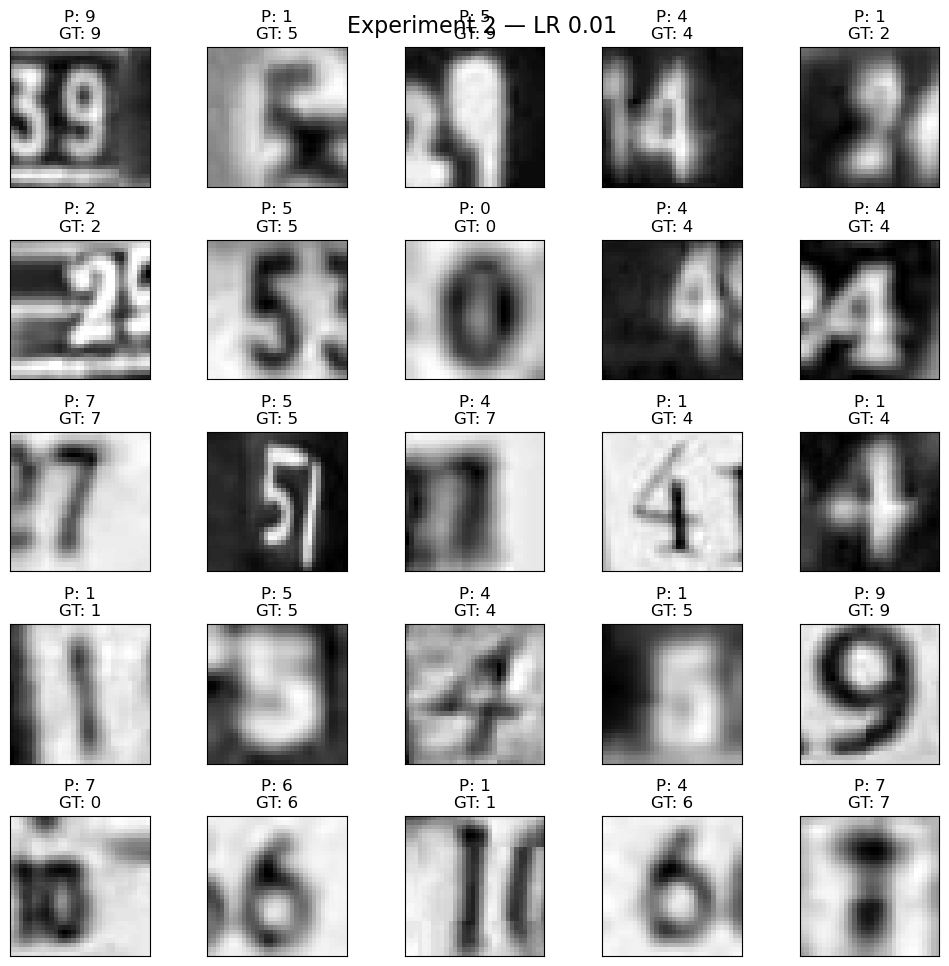

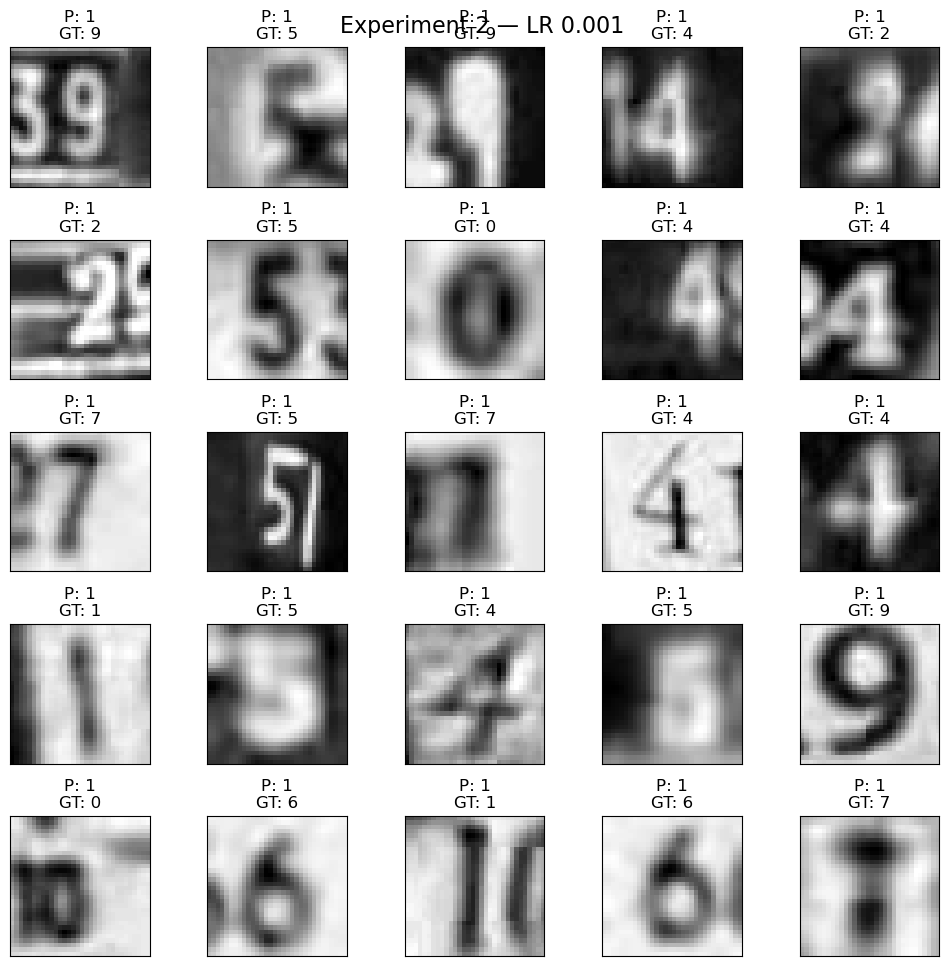

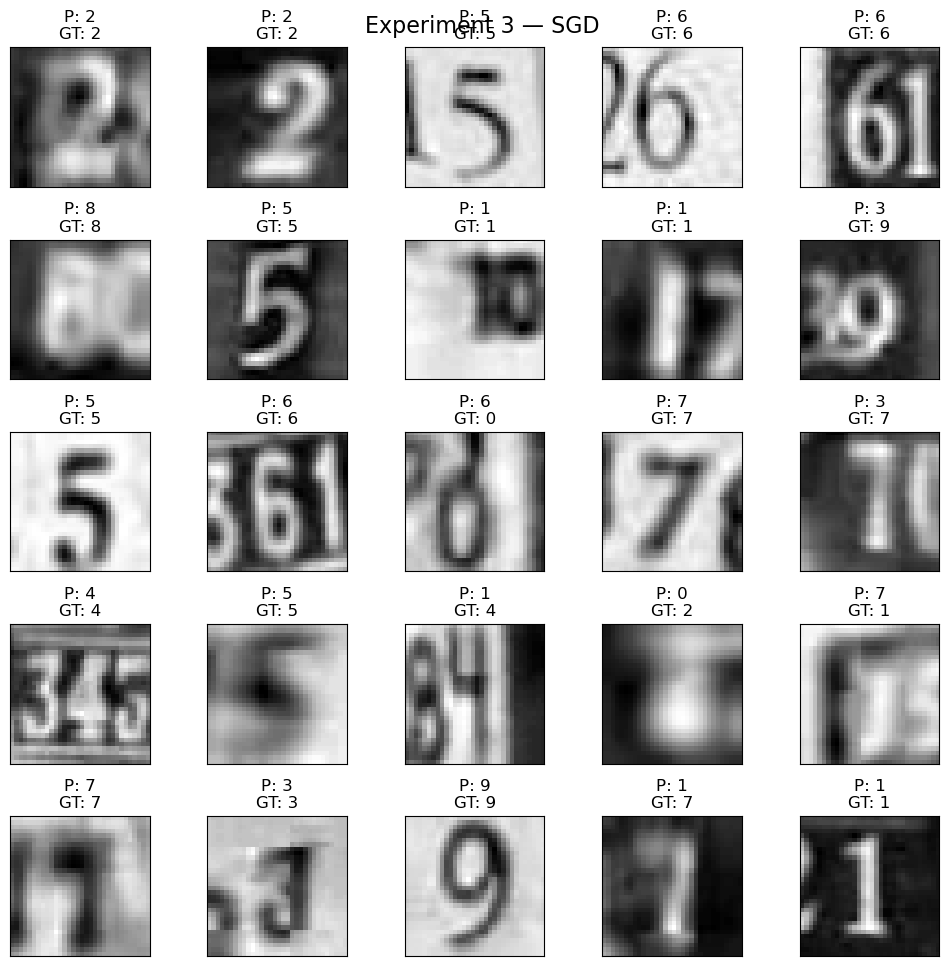

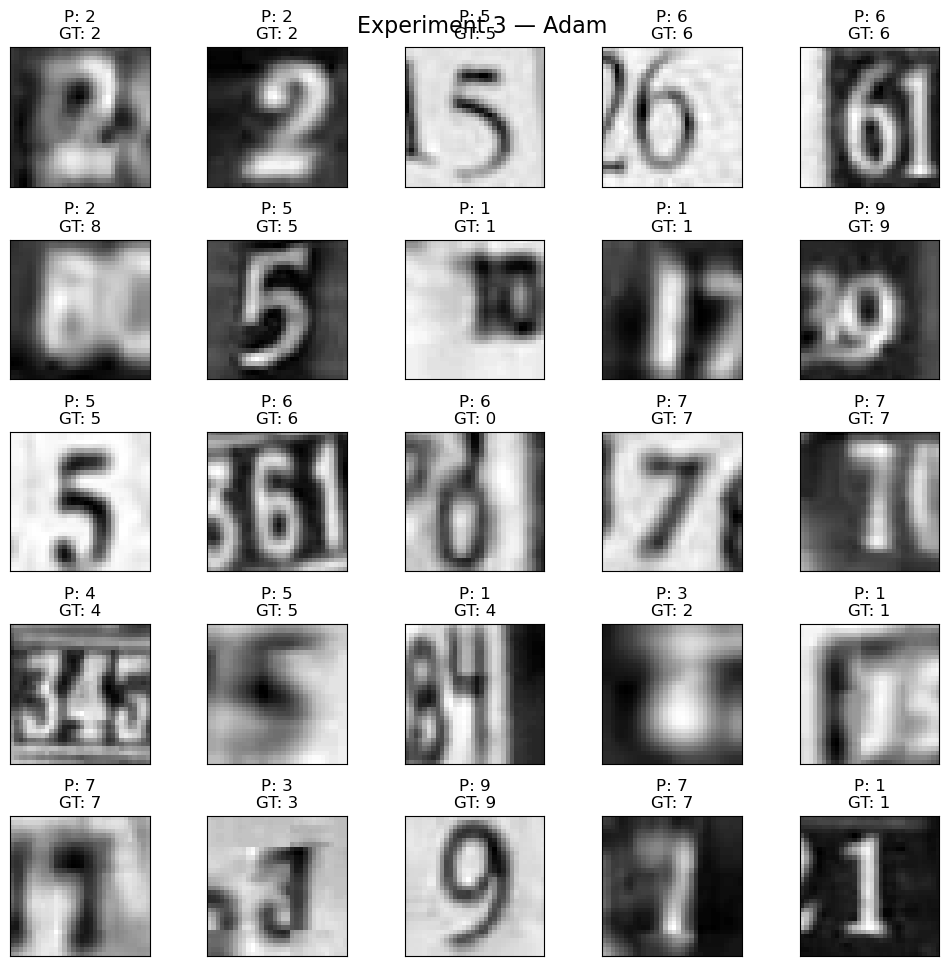

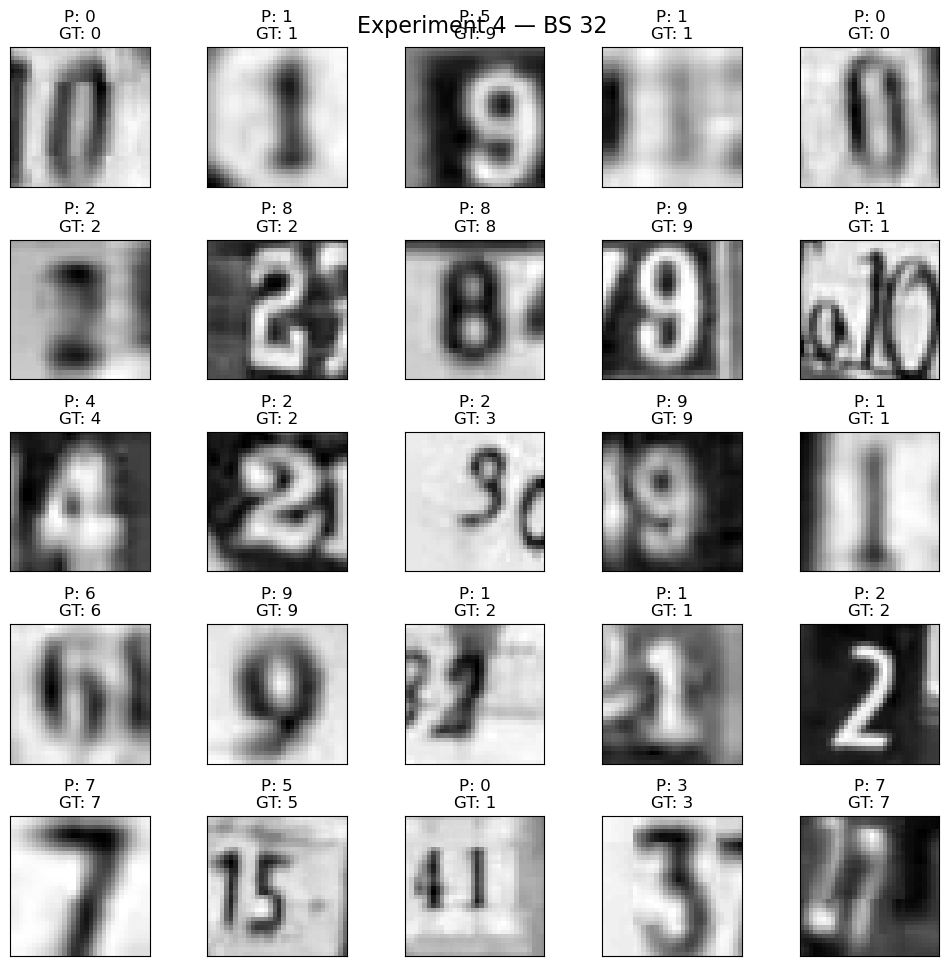

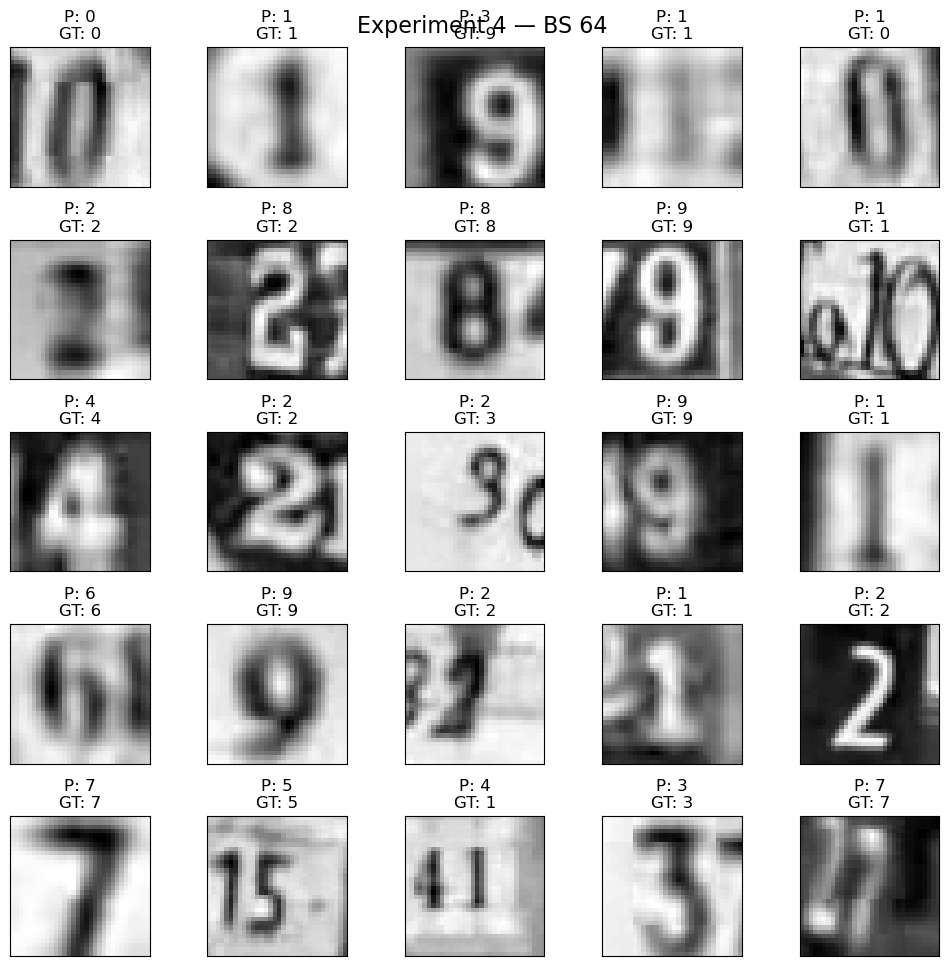

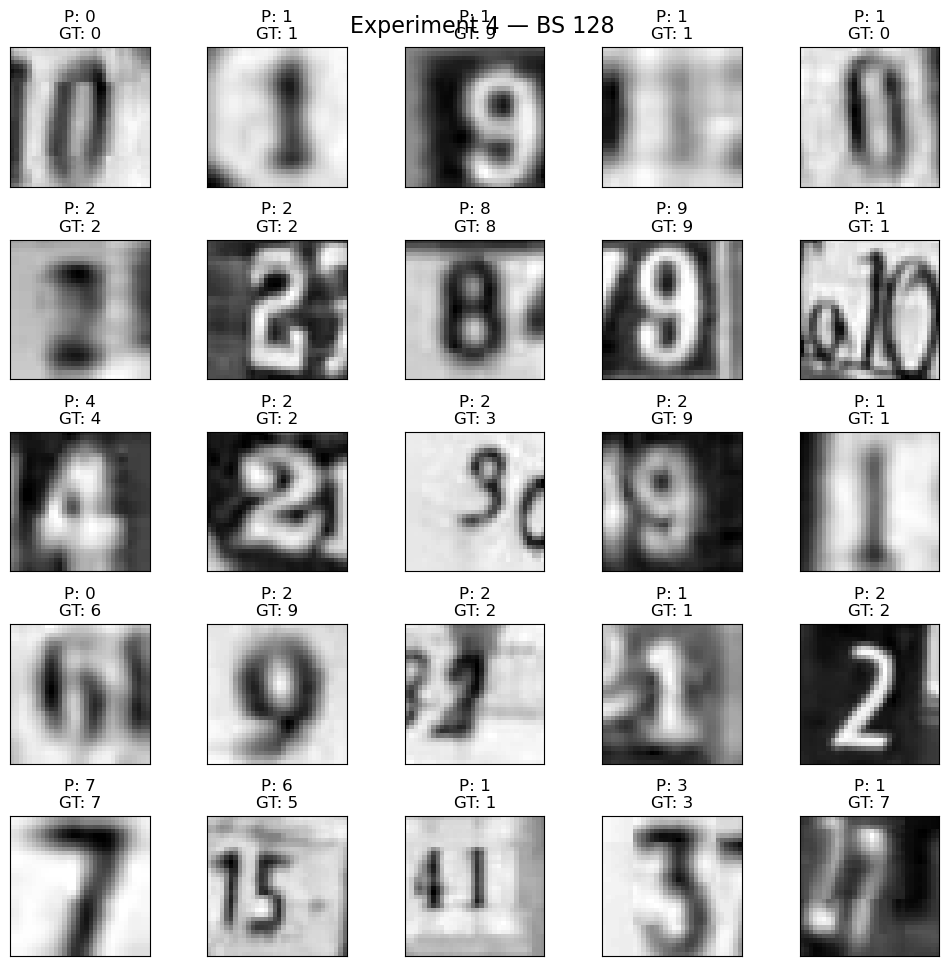

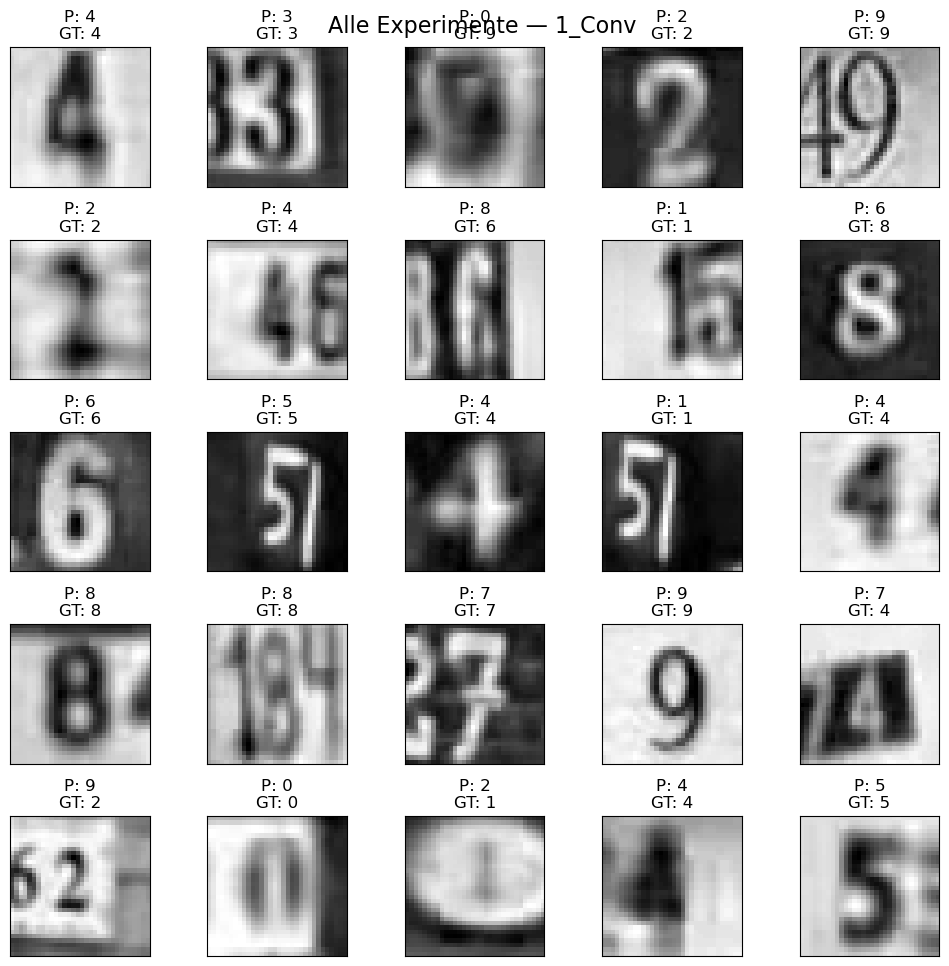

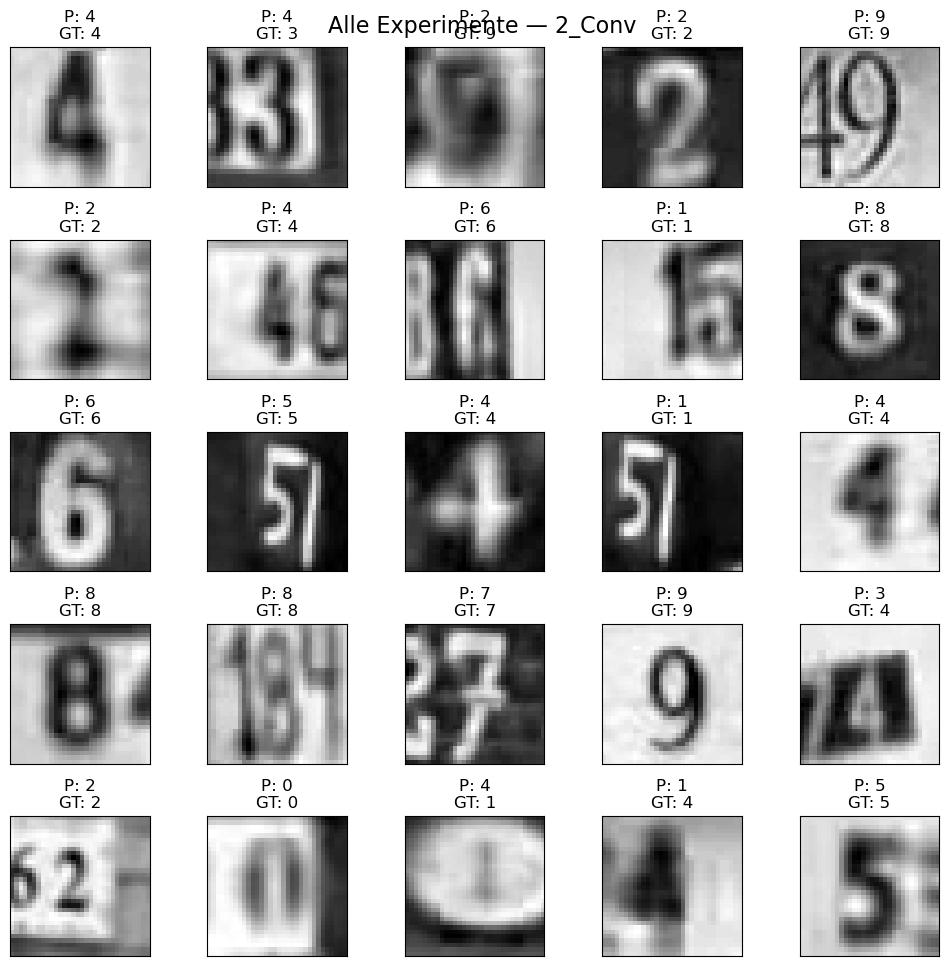

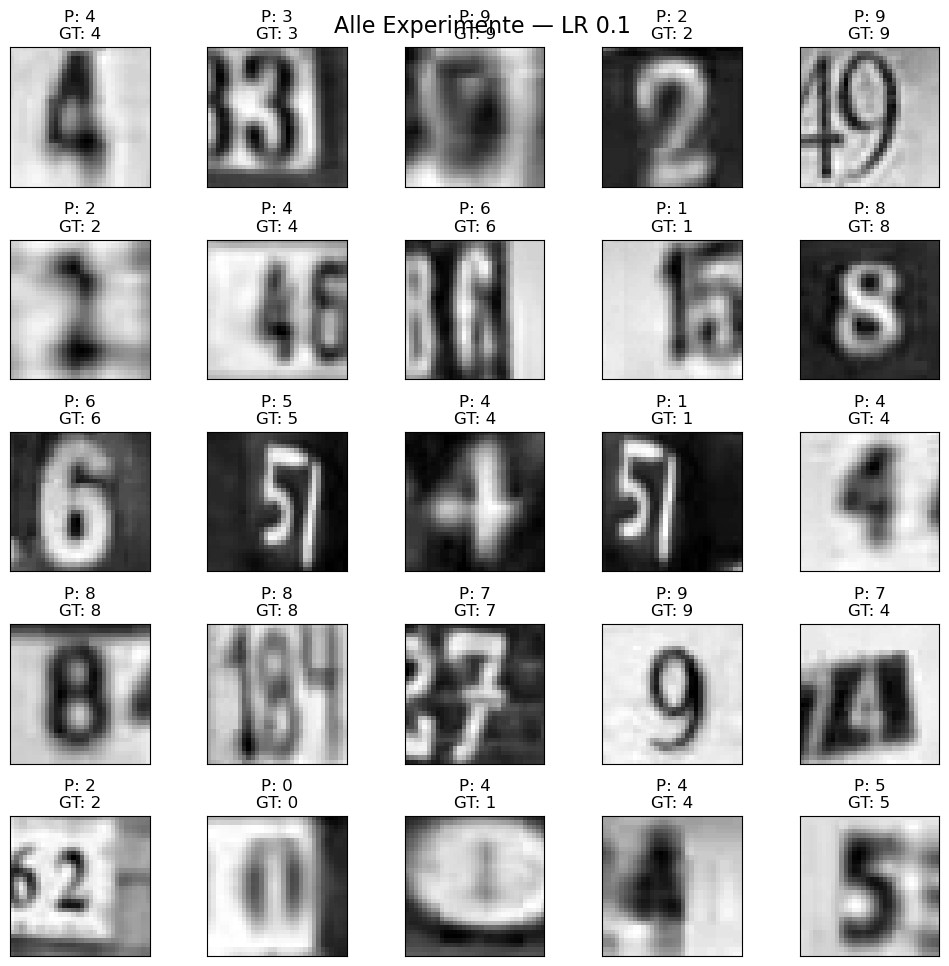

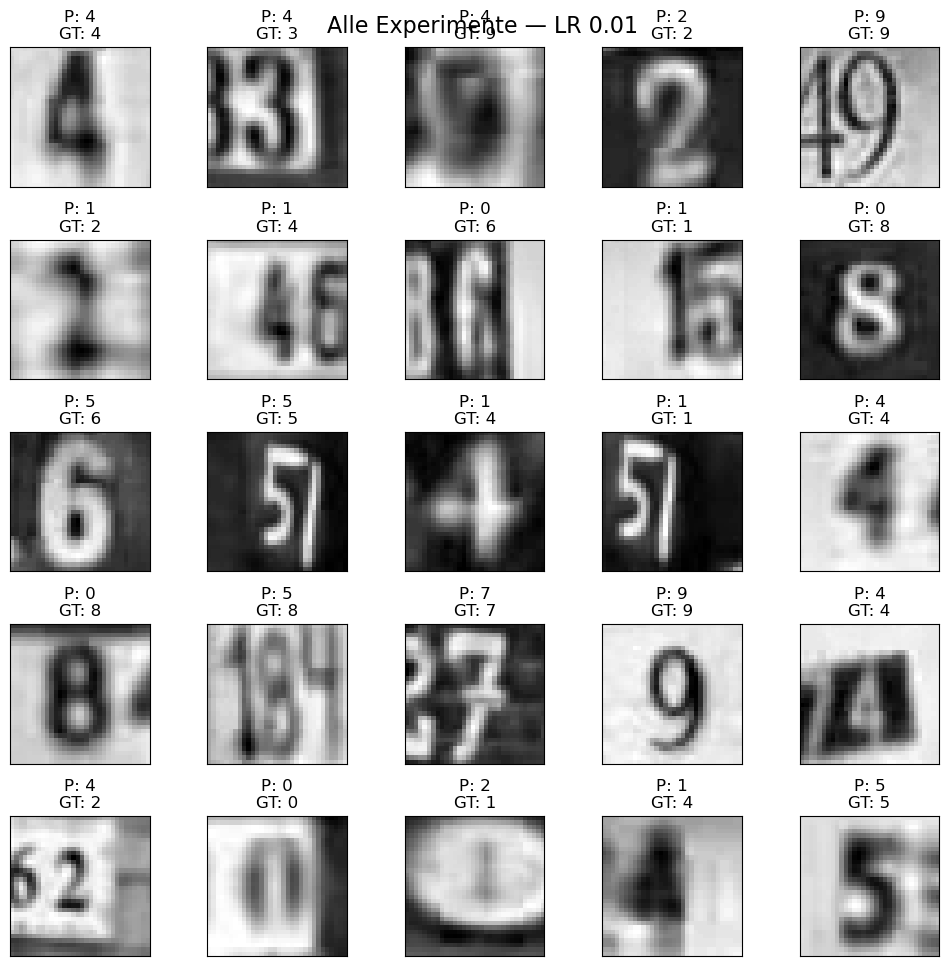

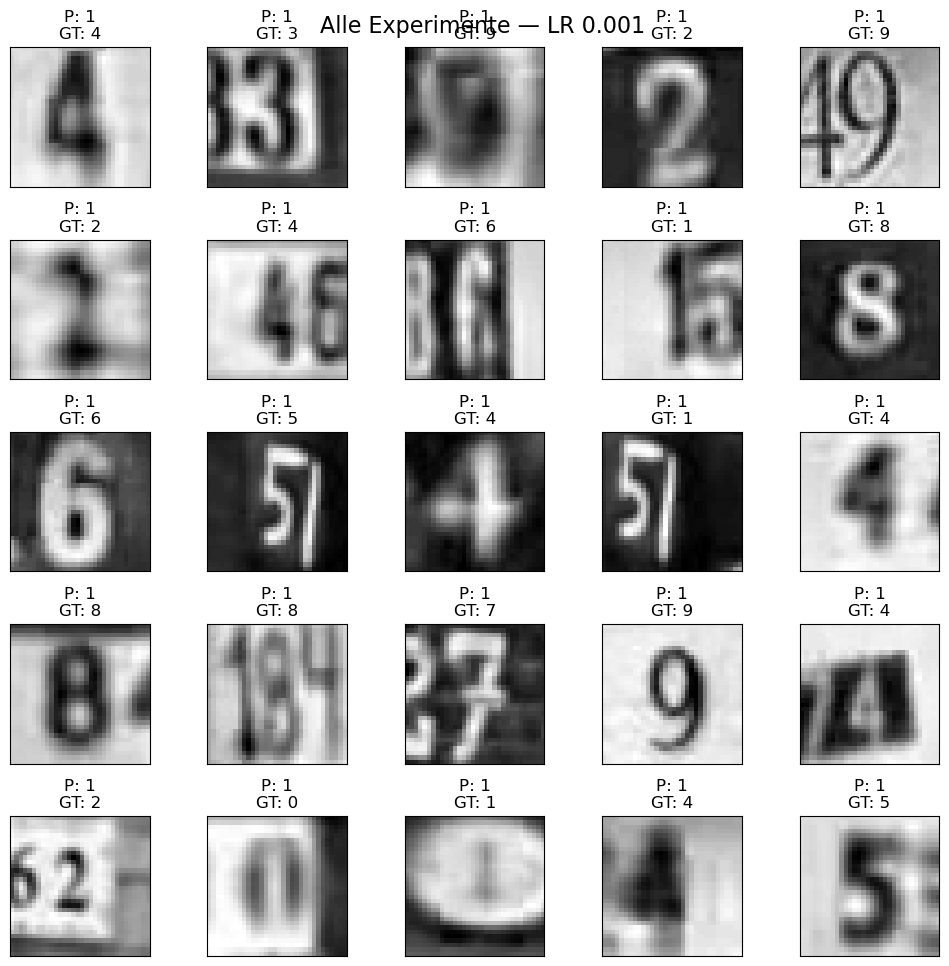

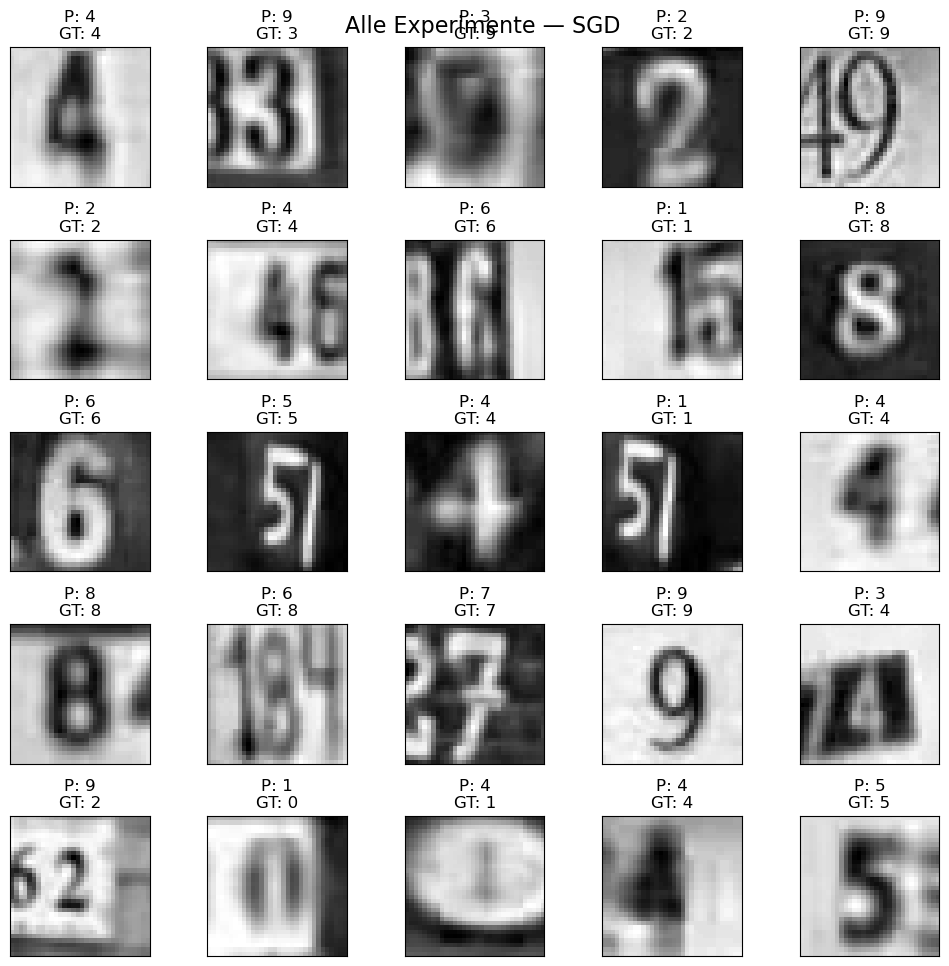

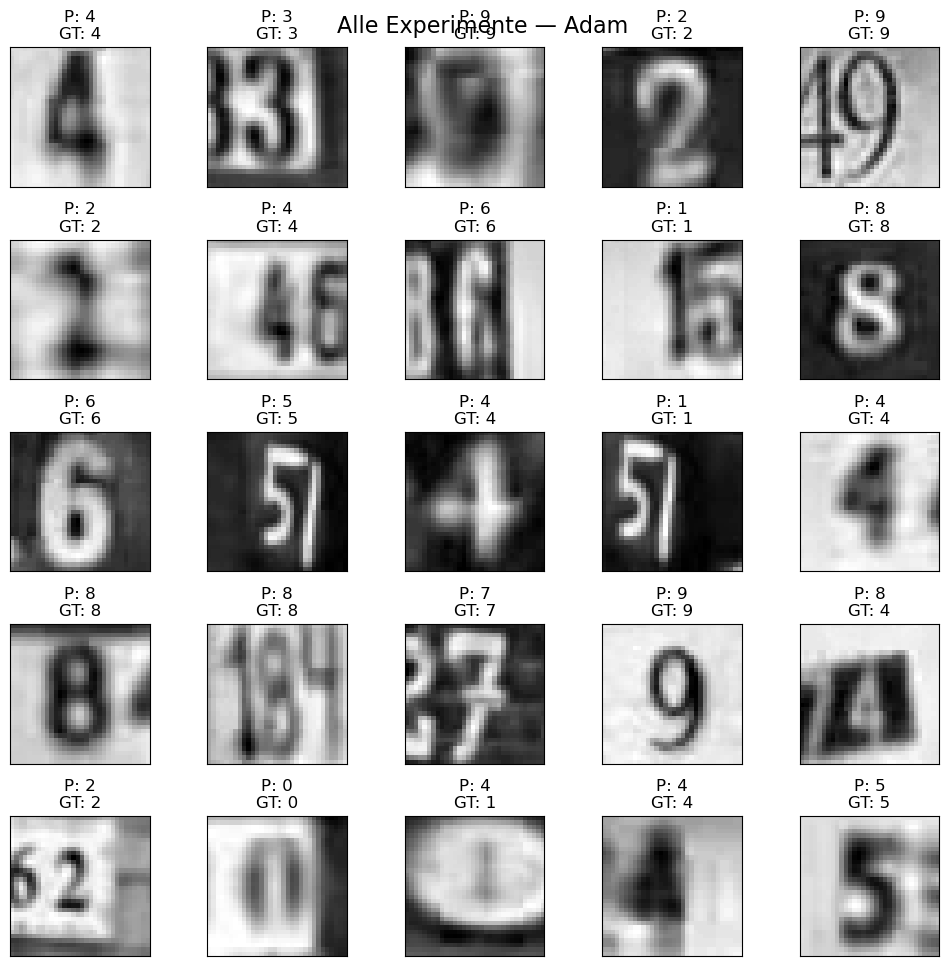

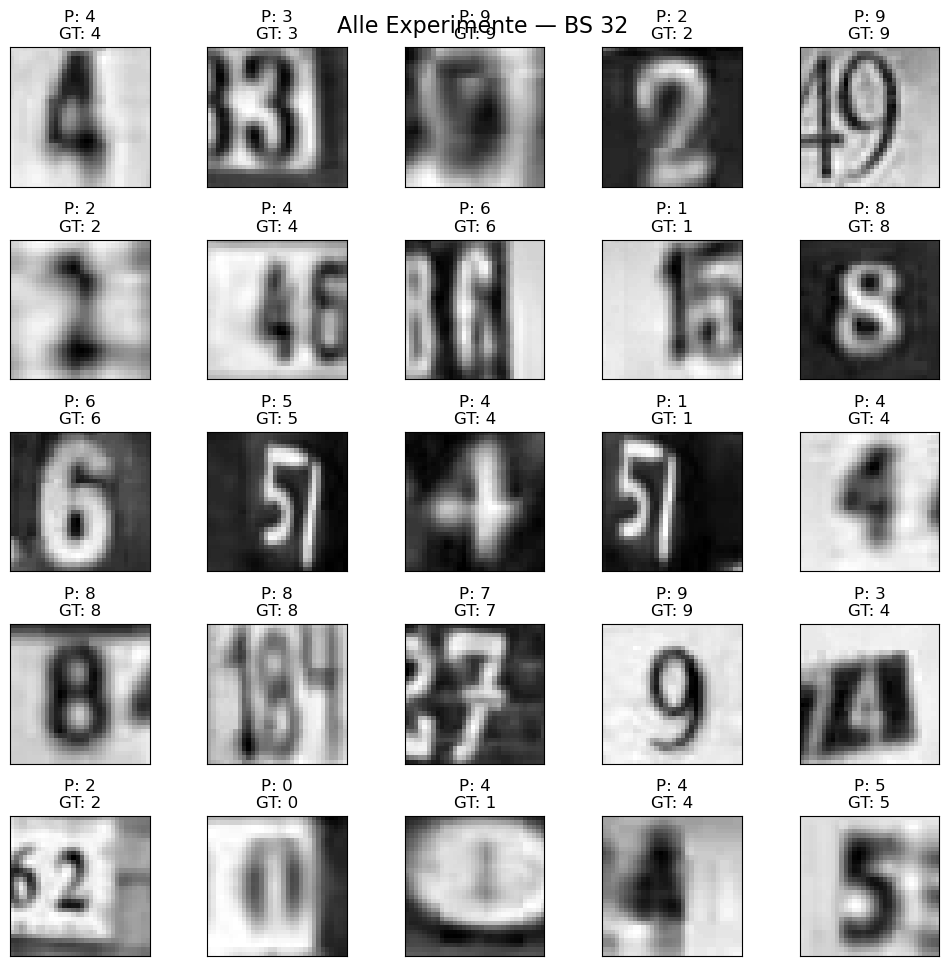

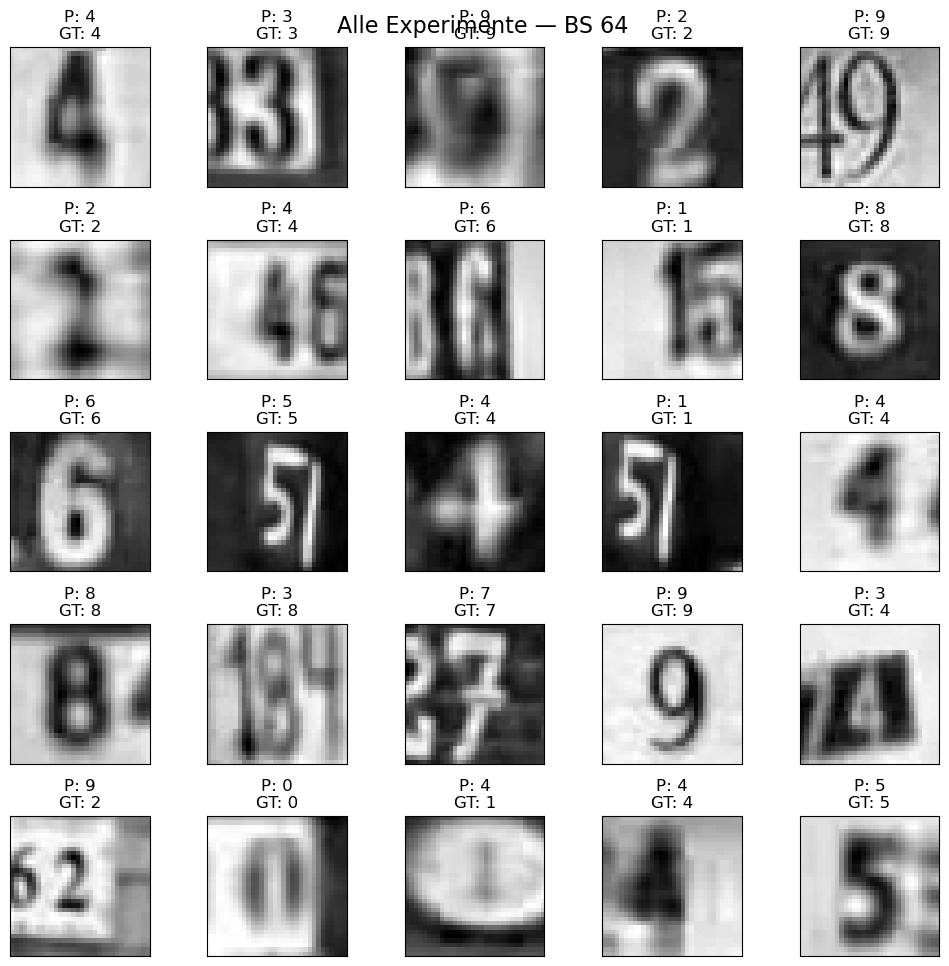

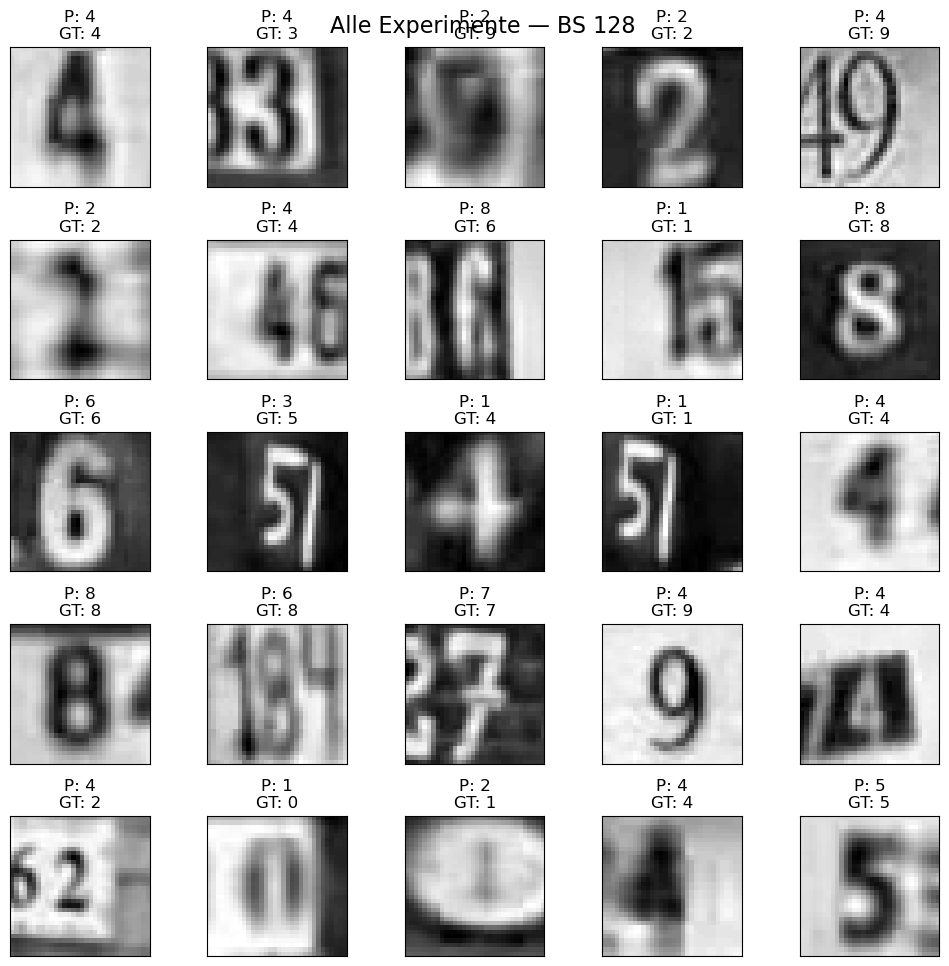

In [87]:
import matplotlib.pyplot as plt
import torch
import random

# --- Funktion: 25 Beispielbilder mit Predictions plotten ---
def plot_sample_predictions(models_dict, test_loader, title_prefix="Experiment"):
    """
    models_dict: Dictionary mit Modellnamen -> trainiertes Modell
    test_loader: DataLoader des Testsets
    title_prefix: Prefix für die Plot-Titel (z.B. "Experiment 1")
    """
    # 25 zufällige Beispiele aus dem Testset auswählen
    example_data, example_targets = next(iter(test_loader))
    num_images = 25
    indices = random.sample(range(len(example_data)), num_images)
    
    for model_name, model in models_dict.items():
        # Vorhersagen berechnen
        model.eval()
        output = model(example_data[indices])
        
        plt.figure(figsize=(10,10))
        for i, idx in enumerate(indices):
            plt.subplot(5,5,i+1)
            plt.tight_layout()
            plt.imshow(example_data[idx][0], cmap='gray', interpolation='none')
            predicted_label = output.data.max(1, keepdim=True)[1][i].item()
            plt.title(f"P: {predicted_label}\nGT: {example_targets[idx]}")
            plt.xticks([])
            plt.yticks([])
        plt.suptitle(f"{title_prefix} — {model_name}", fontsize=16)
        plt.show()


# --- Beispielaufruf für jedes Experiment einzeln ---

# Experiment 1: Netzwerktiefe
models_exp1 = {
    "1_Conv": all_results['Exp1_1_Conv'].get("model"),  # vorher trainiertes Modell speichern, siehe unten
    "2_Conv": all_results['Exp1_2_Conv'].get("model")
}
plot_sample_predictions(models_exp1, test_loader, title_prefix="Experiment 1")

# Experiment 2: Learning Rate
models_exp2 = {f"LR {lr}": all_results[f'Exp2_LR_{lr}'].get("model") for lr in [0.1,0.01,0.001]}
plot_sample_predictions(models_exp2, test_loader, title_prefix="Experiment 2")

# Experiment 3: Optimizer
models_exp3 = {name: all_results[f'Exp3_{name}'].get("model") for name in ["SGD","Adam"]}
plot_sample_predictions(models_exp3, test_loader, title_prefix="Experiment 3")

# Experiment 4: Batch Size
models_exp4 = {f"BS {bs}": all_results[f'Exp4_BS_{bs}'].get("model") for bs in [32,64,128]}
plot_sample_predictions(models_exp4, test_loader, title_prefix="Experiment 4")

# --- Kombinierter Plot aller Experimente ---
all_models = {}
all_models.update(models_exp1)
all_models.update(models_exp2)
all_models.update(models_exp3)
all_models.update(models_exp4)
plot_sample_predictions(all_models, test_loader, title_prefix="Alle Experimente")

